*I'm trying to implement [https://www.quantopian.com/posts/an-empirical-algorithmic-evaluation-of-technical-analysis](https://www.quantopian.com/posts/an-empirical-algorithmic-evaluation-of-technical-analysis) this notebook, using zipline and custom csv data offline.*

# Empirical Algorithmic Implementation of Technical Analysis

# Pattern recognition using algorithms

This is the implementation of a paper by Andrew Lo, Harry Mamaysky, and Jiang Wang called "Foundations of Technical Analysis: Computational Algorithms, Statistical Inference, and Empirical Implementation (2000)" at Quantopian's journal club. In the paper, the authors utilize non-parametric kernel regression to smooth a stock's daily price time series to a point where the local minima and maxima that a human technical analyst would find relevant can be separated from noisier short-term price fluctuations. The authors then search these denoised local minima and maxima for a few of the patterns commonly pursued by technical analysts. Once they've identified occurrences of particular patterns, the authors test their predictive power by observing the subsequent forward return on the stock.

For a fuller explanation of what is going on in this notebook, I encourage you to take a look at the original paper: https://www.cis.upenn.edu/~mkearns/teaching/cis700/lo.pdf

It is interesting to note that since this paper was written in 2000 and all the data used in my implementation is from 2017-2018, my results can be considered to be "out of sample" with respect to the authors' findings.

In [209]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg
from numpy import linspace
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipline
from yahoofinancials import YahooFinancials
import warnings
import pandas_datareader as pdr
plt.style.use('seaborn')

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Fetching Microsoft stocks prices using pandas data reader library

In [211]:
msft_prices = pdr.get_data_yahoo('MSFT', '2003-1-1', '2016-5-1')['Close']

In [212]:
msft_prices.head()

Date
2003-01-02    26.860001
2003-01-03    26.895000
2003-01-06    27.385000
2003-01-07    27.900000
2003-01-08    27.120001
Name: Close, dtype: float64

In [35]:
prices_ = msft_prices.copy()
prices_.index = linspace(1., len(prices_), len(prices_))


In [36]:
# I've chosen bandwith parameters manually. This is something that could be improved.
kr = KernelReg([prices_.values], [prices_.index.values], var_type='c', bw=np.full((1, 1), 1.8))
f = kr.fit([prices_.index.values])
smooth_prices = pd.Series(data=f[0], index=msft_prices.index)

In our application, a kernel regression estimates some function $m(x)$ given (time, price) observations $(x_1, P_1) ... (x_t, P_t)$ where $t = 1...T$. The value of $m(x)$ is computed by taking weighted average of the prices in the timeseries, where the weight assigned to observation $P_t$ is determinded by its distance from x. This distance weight is described by a "kernel" fuction $w(x)$. The authors use a gausian kernel with a manually tuned bandwidth parameter.


$$m(x) = \frac{1}{T}\sum_{t=1}^{T}w_t(x)P_t$$ 



In [37]:
msft_prices.head()

Date
2003-01-02    26.860001
2003-01-03    26.895000
2003-01-06    27.385000
2003-01-07    27.900000
2003-01-08    27.120001
Name: Close, dtype: float64

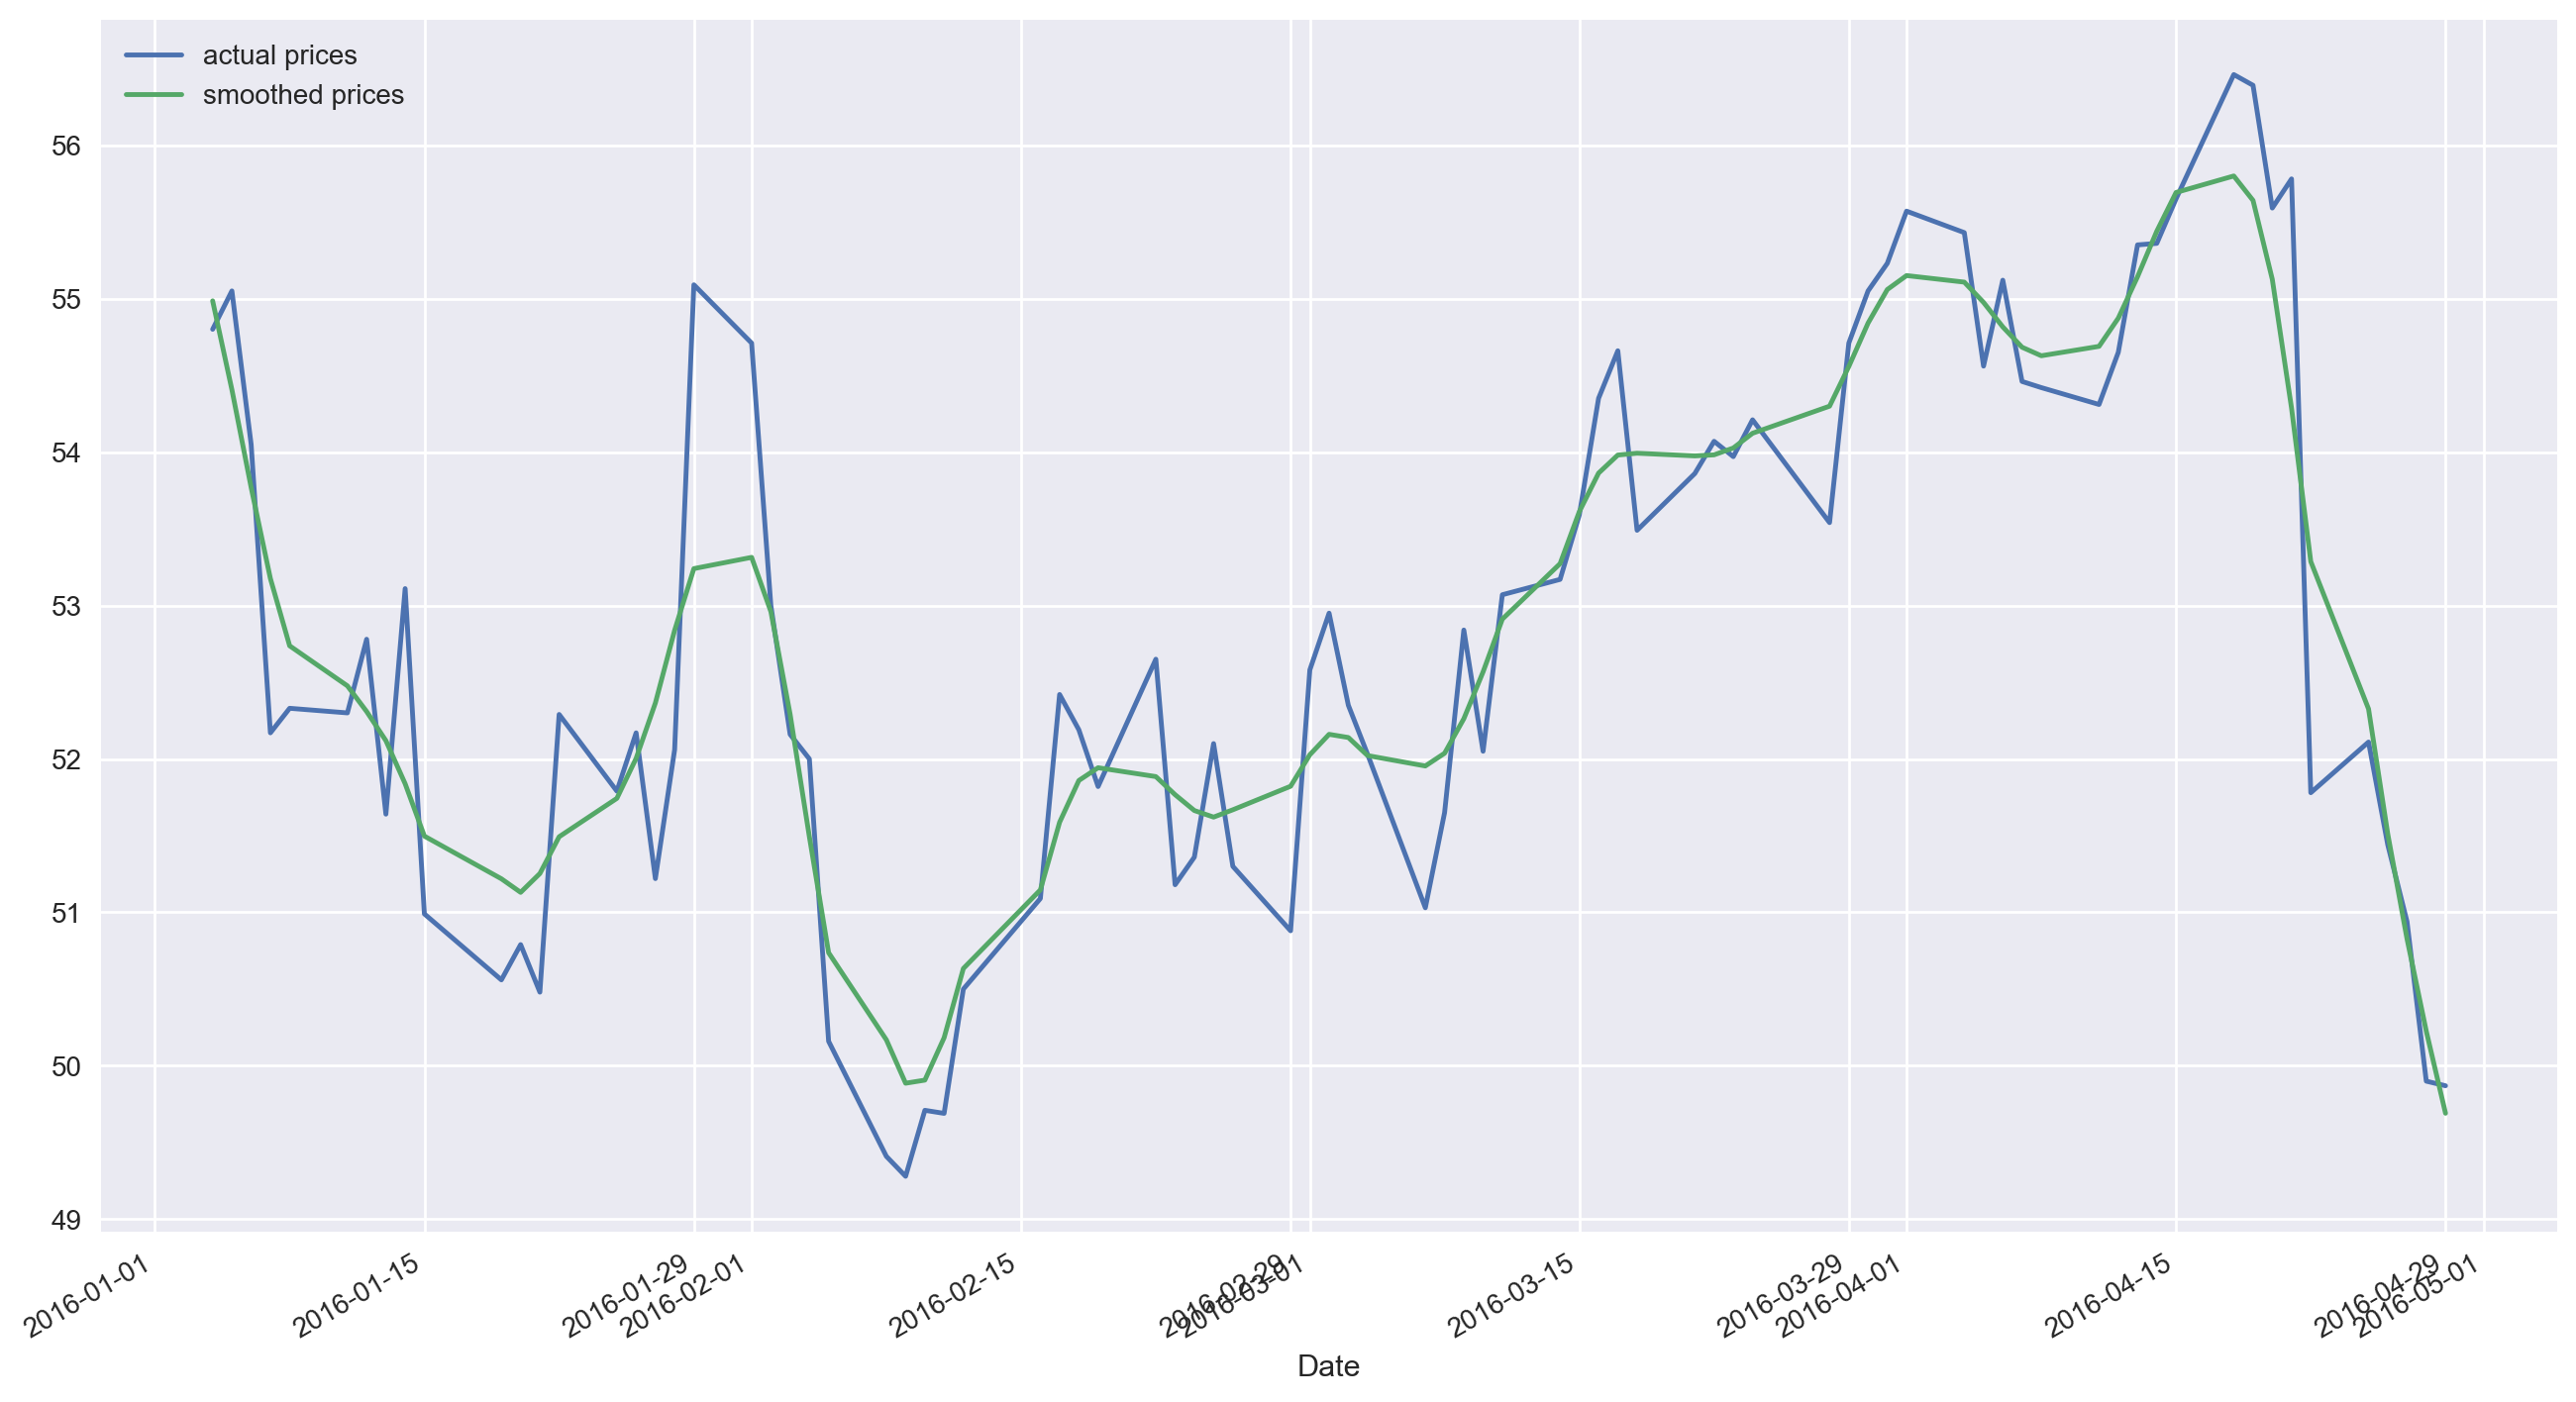

In [38]:
msft_prices.loc[pd.datetime(2016,1,1):].plot()
smooth_prices.loc[pd.datetime(2016,1,1):].plot()
plt.legend(['actual prices', 'smoothed prices'])

From this smoothed price timeseries we can extract local minima and maxima (orange points in the plots below.)

The author use the minima and maxima from the smoothed timeseries to identify true local minima and maxima in the original timeseres by taking the maximum/minimum price within a t-1, t+1 window around the smooth timeseries maxima/minima (purple points in the plots below). We use these minima and maxima from the original price data to look for the given technical patterns.

You can see in the plots below, that finding minima and maxima using the kernel regression allows us to skip over minima and maxima that are *too local*.

In [39]:
from scipy.signal import argrelextrema

In [40]:
local_max = argrelextrema(smooth_prices.values, np.greater)[0]
local_min = argrelextrema(smooth_prices.values, np.less)[0]

In [41]:
local_max_dt = smooth_prices.iloc[local_max].index.values
local_min_dt = smooth_prices.iloc[local_min].index.values

In [42]:
price_local_max_dt = []
for i in local_max:
    if (i>1) and (i<len(msft_prices)-1):
        price_local_max_dt.append(msft_prices.iloc[i-2:i+2].argmax())

price_local_min_dt = []
for i in local_min:
    if (i>1) and (i<len(msft_prices)-1):
        price_local_min_dt.append(msft_prices.iloc[i-2:i+2].argmin())

In [43]:
(msft_prices.index)

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2016-04-18', '2016-04-19', '2016-04-20', '2016-04-21',
               '2016-04-22', '2016-04-25', '2016-04-26', '2016-04-27',
               '2016-04-28', '2016-04-29'],
              dtype='datetime64[ns]', name='Date', length=3355, freq=None)

## Let us have a look at all the patterns

#### Head and shoulders
![image.png](https://www.investopedia.com/thmb/po7ymUOivi6Djv58zBFEgRGbld0=/250x250/smart/filters:no_upscale()/HeadandShoulder_050906-5bfd6ce1c9e77c0058b0ac04)

#### Inverse Head and Shoulders
![](https://school.stockcharts.com/lib/exe/fetch.php?media=chart_analysis:chart_patterns:head_and_shoulders_bottom_reversal:hs-botslopup-frx.png)

#### Broadening Top
![](http://www.finvids.com/Content/Images/ChartPattern/Broadening-Top-Bottom/Broadening-Top.jpg)

#### Broadening Bottom
![](https://www.finvids.com/Content/Images/ChartPattern/Broadening-Top-Bottom/Broadening-Bottom-Chart-Example.jpg)

#### Triangle Top
![](![image.png](attachment:image.png))
#### Triangle Bottom
![](https://school.stockcharts.com/lib/exe/fetch.php?media=chart_analysis:chart_patterns:descending_triangle_continuation:desctri-conti-dd.png)
#### Rectangle Top 
![](https://school.stockcharts.com/lib/exe/fetch.php?media=chart_analysis:chart_patterns:rectangle_continuation:rect-conti-mu.png)






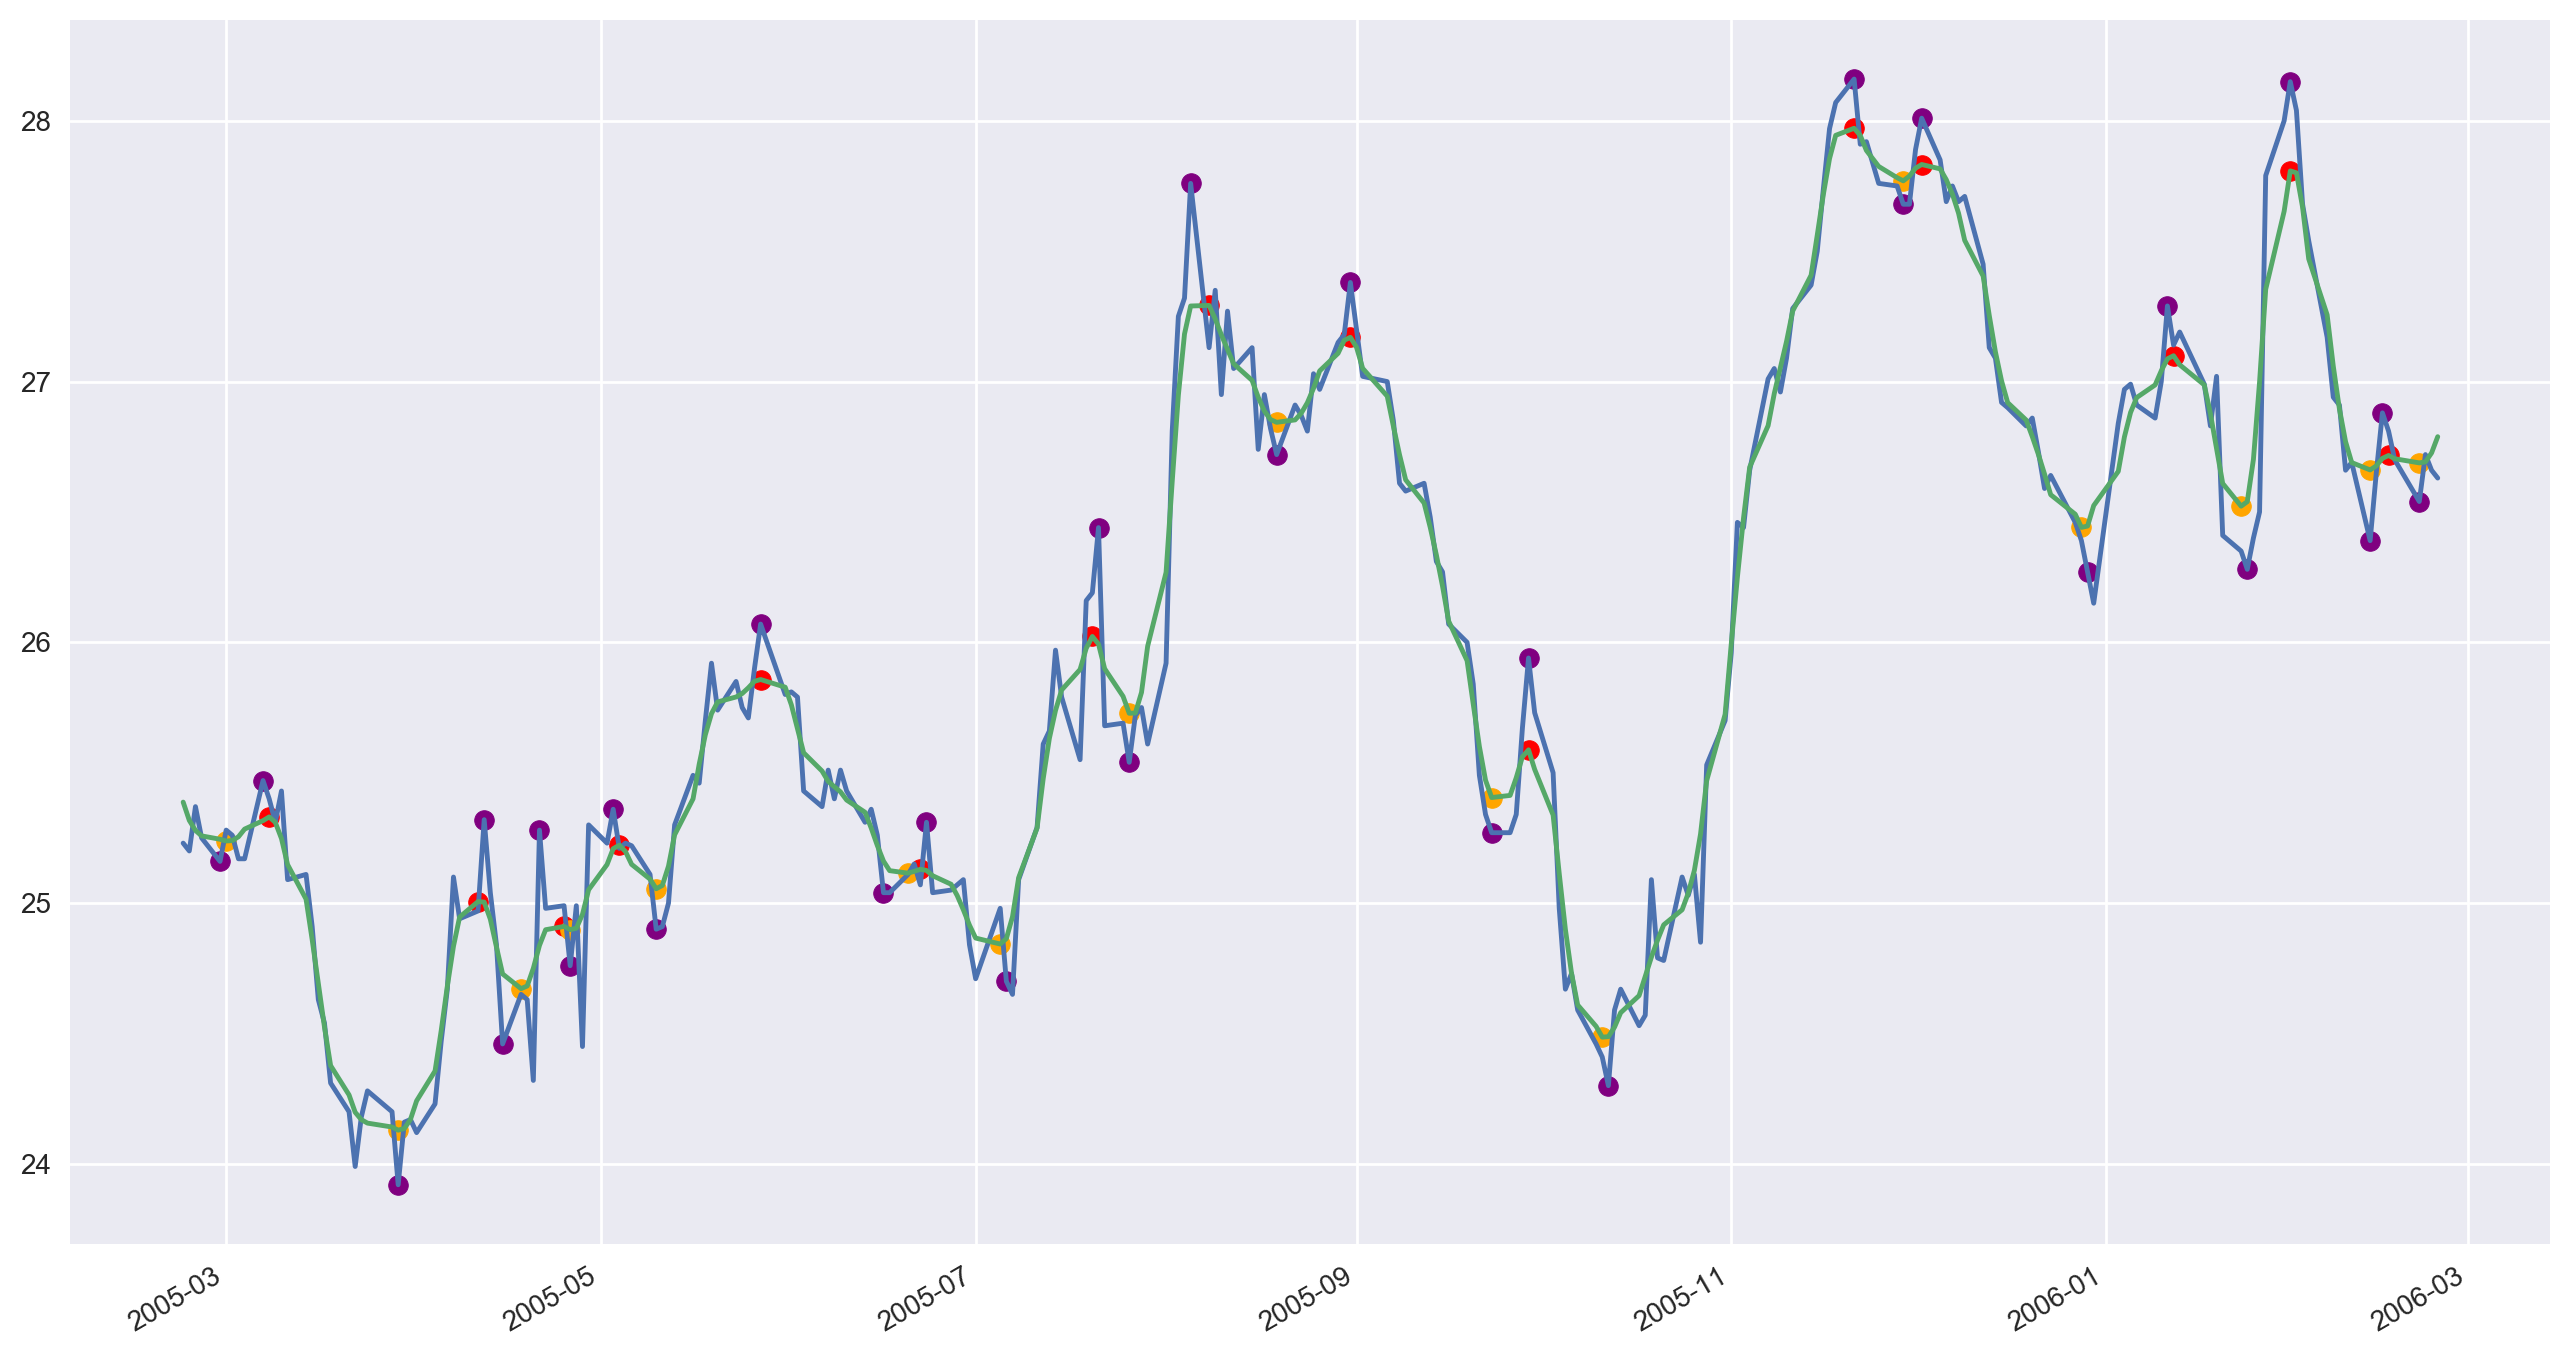

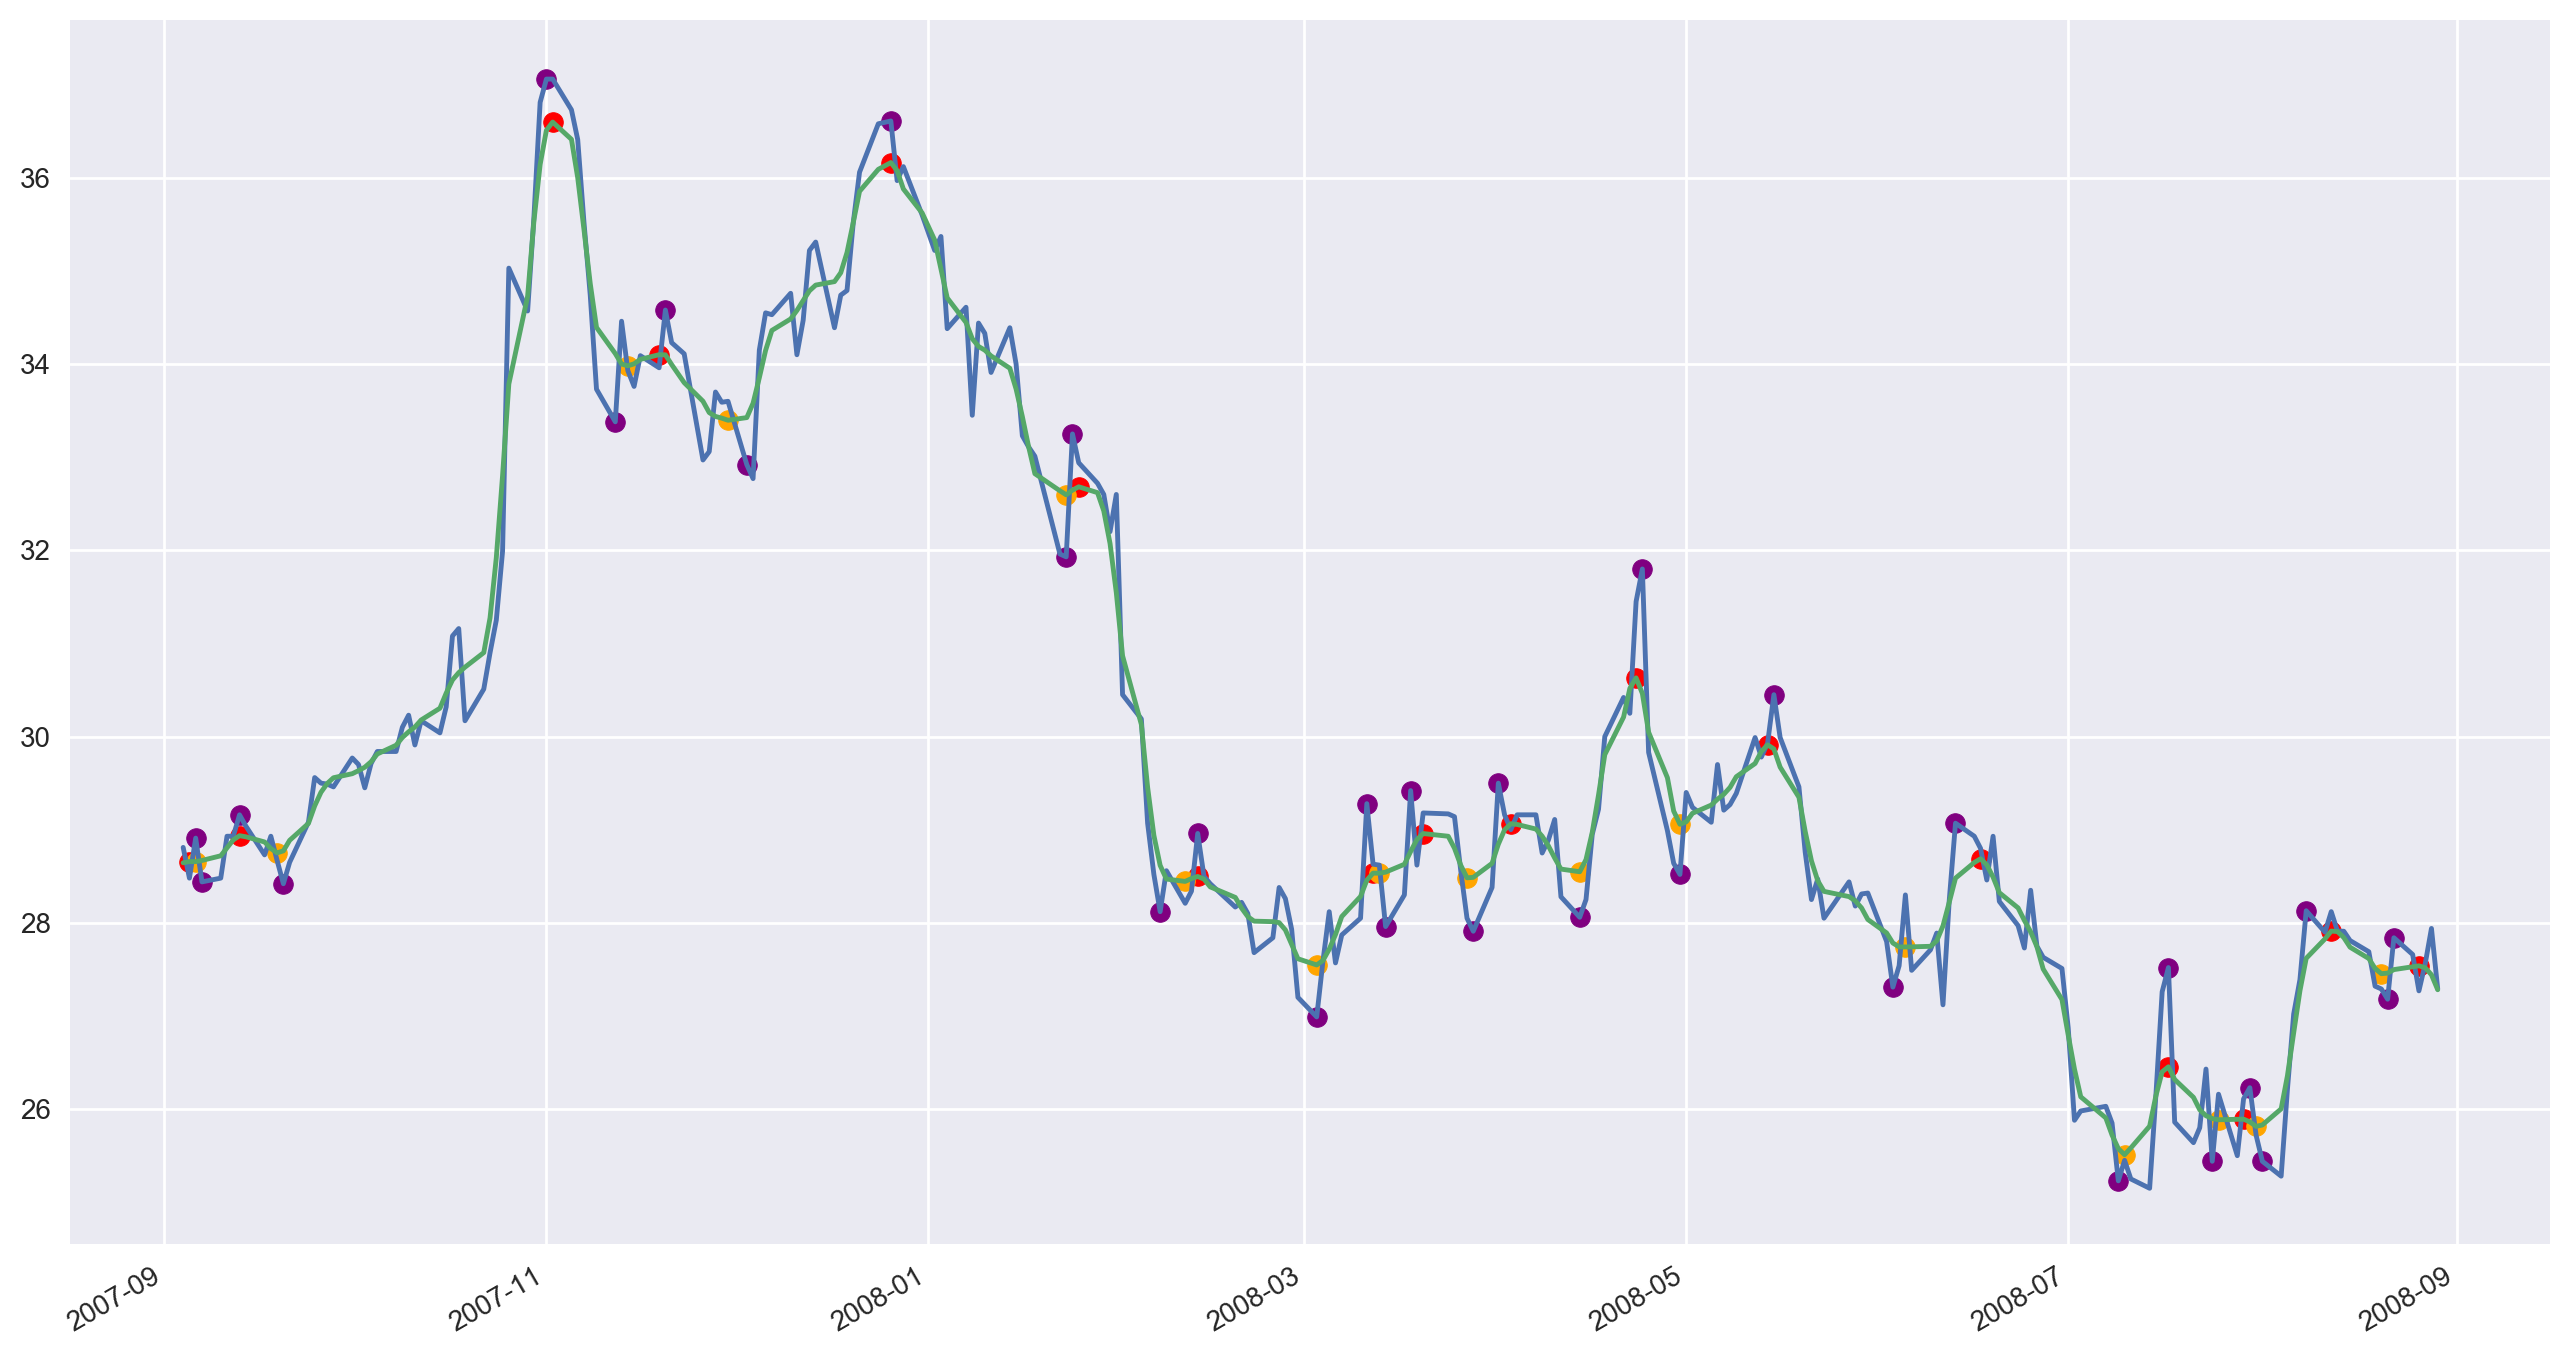

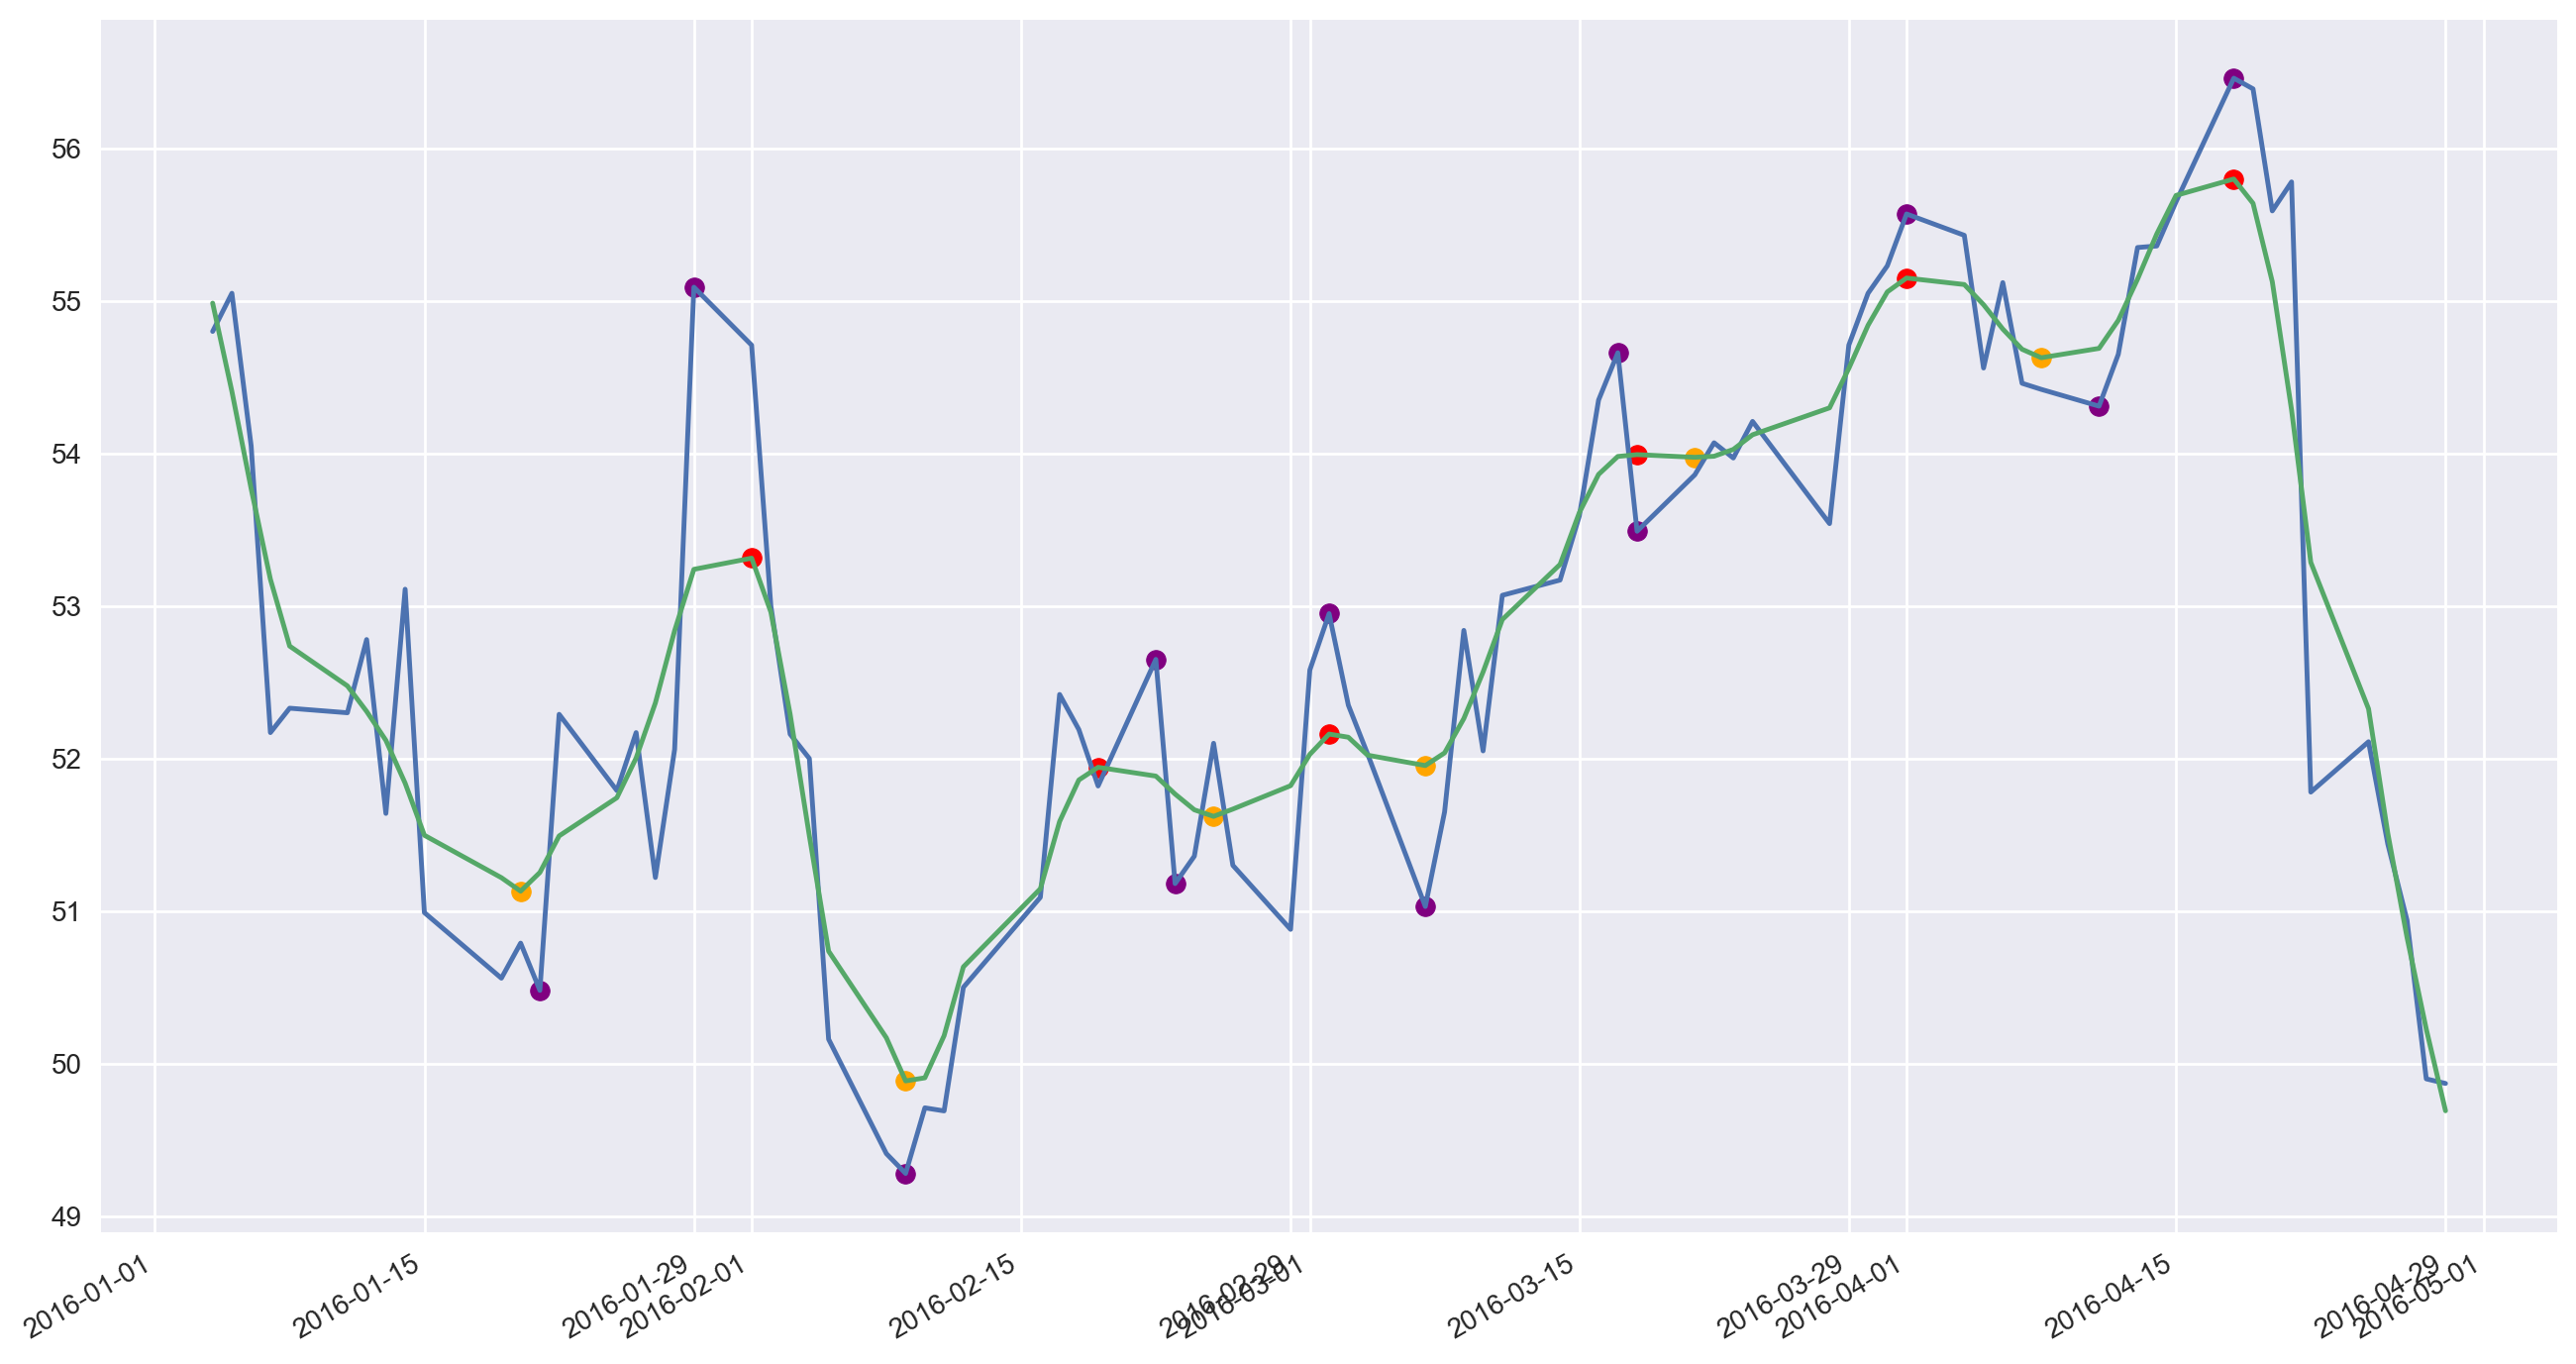

In [44]:
start = pd.datetime(2015,1,1)
end = pd.datetime(2015,4,1)
from datetime import datetime

def plot_window(prices, smooth_prices, smooth_maxima_dt, smooth_minima_dt,
                price_maxima_dt, price_minima_dt, start, end, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    prices_ = prices.loc[start:end]
    prices_.index= [datetime.strptime(d, '%Y-%m-%d') for d in pd.to_datetime(prices_.index).strftime('%Y-%m-%d')]
    prices_.plot(ax=ax)
    
    smooth_prices_ = smooth_prices.loc[start:end]
    smooth_prices_.index= [datetime.strptime(d, '%Y-%m-%d') for d in pd.to_datetime(smooth_prices_.index).strftime('%Y-%m-%d')]
    smooth_prices_.plot(ax=ax)

    smooth_max = smooth_prices_.loc[smooth_maxima_dt]
    smooth_min = smooth_prices_.loc[smooth_minima_dt]
    price_max = prices_.loc[price_maxima_dt]
    price_min = prices_.loc[price_minima_dt]
    
    ax.scatter(smooth_max.index, smooth_max, s=50, color='red' )
    ax.scatter(smooth_min.index, smooth_min, s=50, color='orange')
    ax.scatter(price_max.index, price_max, s=50, color='purple')
    ax.scatter(price_min.index, price_min, s=50, color='purple')
    
    
plot_window(msft_prices, smooth_prices, local_max_dt, local_min_dt, price_local_max_dt, 
            price_local_min_dt, pd.datetime(2005,2,19), pd.datetime(2006,2,26))
plot_window(msft_prices, smooth_prices, local_max_dt, local_min_dt, price_local_max_dt, 
            price_local_min_dt,pd.datetime(2007,9,1), pd.datetime(2008,9,1))
plot_window(msft_prices, smooth_prices, local_max_dt, local_min_dt, price_local_max_dt, 
            price_local_min_dt, pd.datetime(2016,1,1), pd.datetime(2016,5,1))


In [45]:
# Let's throw what we have so far into a function:
def find_max_min(prices):
    prices_ = prices.copy()
    prices_.index = linspace(1., len(prices_), len(prices_))
    kr = KernelReg([prices_.values], [prices_.index.values], var_type='c',  bw=np.full((1, 1), 1.8))
    f = kr.fit([prices_.index.values])
    smooth_prices = pd.Series(data=f[0], index=prices.index)
    
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    
    price_local_max_dt = []
    for i in local_max:
        if (i>1) and (i<len(prices)-1):
            price_local_max_dt.append(prices.iloc[i-2:i+2].argmax())

    price_local_min_dt = []
    for i in local_min:
        if (i>1) and (i<len(prices)-1):
            price_local_min_dt.append(prices.iloc[i-2:i+2].argmin())
        
    prices.name = 'price'
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()
    max_min['day_num'] = p[p['Date'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num').price
    
    return max_min

In [46]:
max_min = find_max_min(msft_prices)

# Pattern Identification

You can find the pattern definitions on page 1716 of the paper. 

In [47]:
from collections import defaultdict

def find_patterns(max_min):
    patterns = defaultdict(list)

    for i in range(5, len(max_min)):
        window = max_min.iloc[i-5:i]

        # pattern must play out in less than 36 days
        if window.index[-1] - window.index[0] > 35:
            continue

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1,e3,e5])
        rtop_g2 = np.mean([e2,e4])
        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
            (abs(e1 - e5) <= 0.03*np.mean([e1,e5])) and \
            (abs(e2 - e4) <= 0.03*np.mean([e1,e5])):
                patterns['HS'].append((window.index[0], window.index[-1]))

        # Inverse Head and Shoulders
        elif (e1 < e2) and (e3 < e1) and (e3 < e5) and \
            (abs(e1 - e5) <= 0.03*np.mean([e1,e5])) and \
            (abs(e2 - e4) <= 0.03*np.mean([e1,e5])):
                patterns['IHS'].append((window.index[0], window.index[-1]))

        # Broadening Top
        elif (e1 > e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['BTOP'].append((window.index[0], window.index[-1]))

        # Broadening Bottom
        elif (e1 < e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['BBOT'].append((window.index[0], window.index[-1]))

        # Triangle Top
        elif (e1 > e2) and (e1 > e3) and (e3 > e5) and (e2 < e4):
            patterns['TTOP'].append((window.index[0], window.index[-1]))

        # Triangle Bottom
        elif (e1 < e2) and (e1 < e3) and (e3 < e5) and (e2 > e4):
            patterns['TBOT'].append((window.index[0], window.index[-1]))

        # Rectangle Top
        elif (e1 > e2) and (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
            (min(e1, e3, e5) > max(e2, e4)):

            patterns['RTOP'].append((window.index[0], window.index[-1]))

        # Rectangle Bottom
        elif (e1 < e2) and (abs(e1-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e3-rtop_g1)/rtop_g1 < 0.0075) and (abs(e5-rtop_g1)/rtop_g1 < 0.0075) and \
            (abs(e2-rtop_g2)/rtop_g2 < 0.0075) and (abs(e4-rtop_g2)/rtop_g2 < 0.0075) and \
            (max(e1, e3, e5) > min(e2, e4)):
            patterns['RBOT'].append((window.index[0], window.index[-1]))
            
    return patterns


In [48]:
patterns = find_patterns(max_min)

In [49]:
msft_prices.head()

Date
2003-01-02    26.860001
2003-01-03    26.895000
2003-01-06    27.385000
2003-01-07    27.900000
2003-01-08    27.120001
Name: price, dtype: float64

Visualizing pattern occurences

TBOT


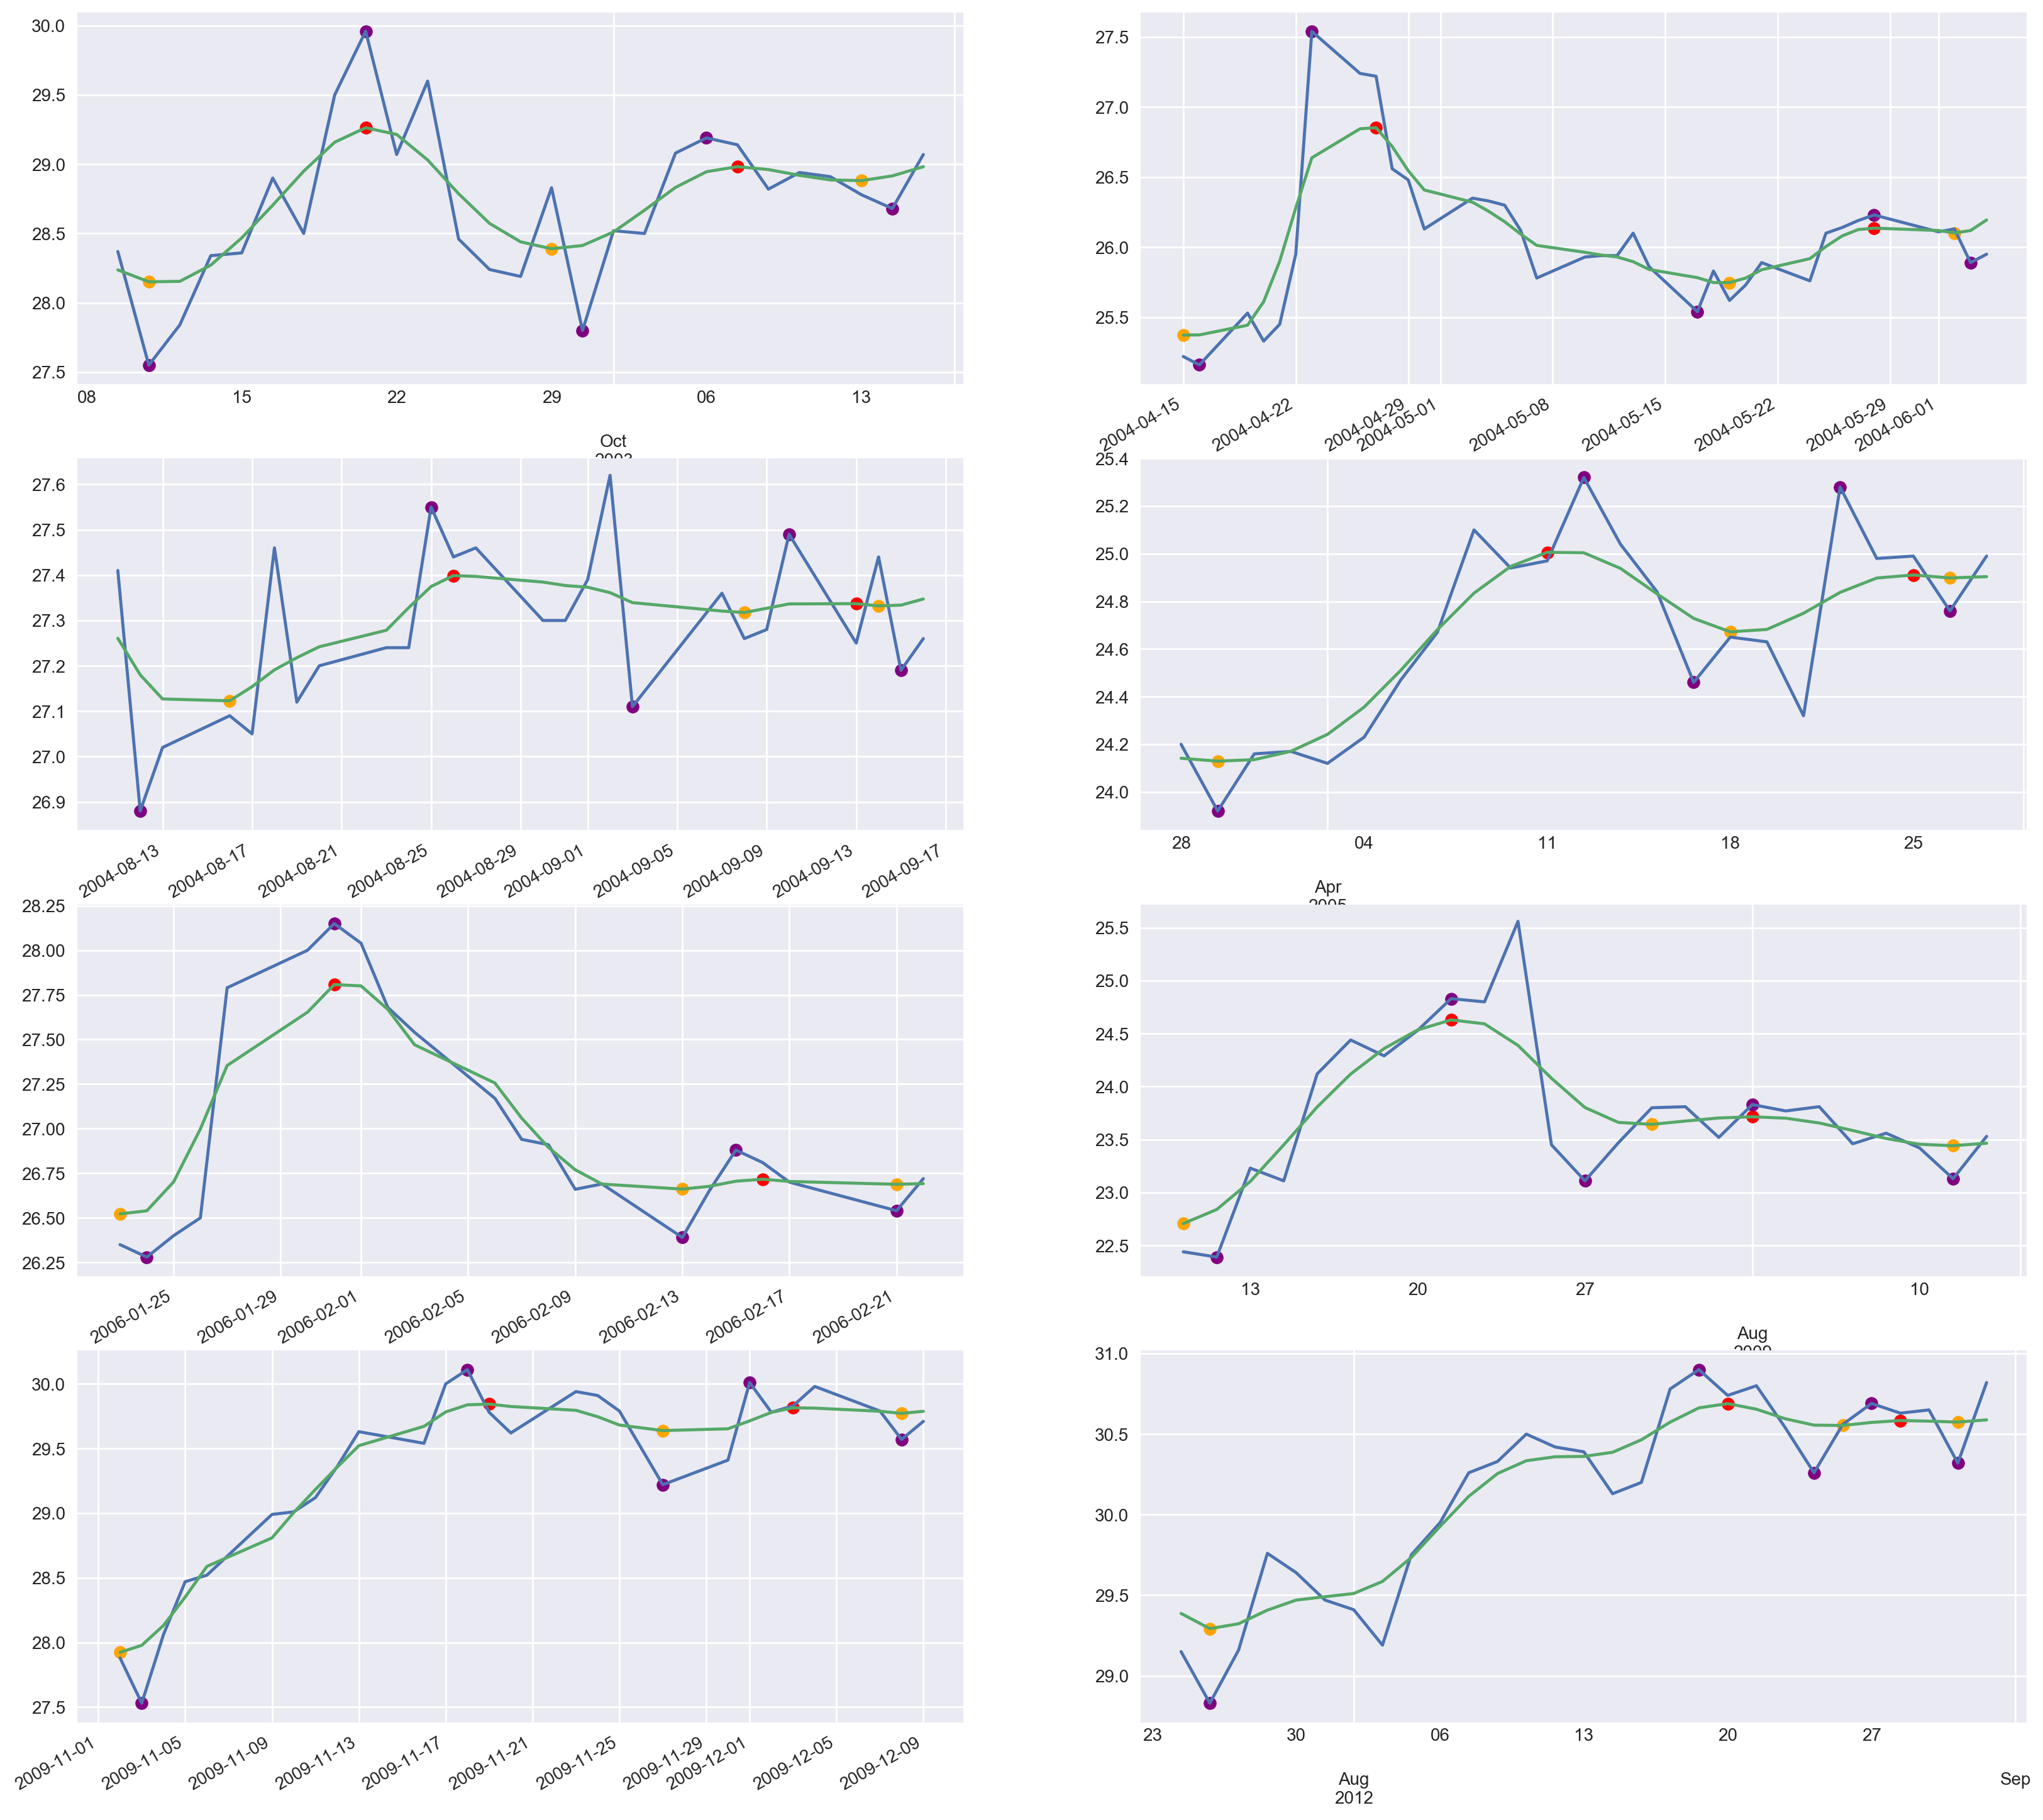

BTOP


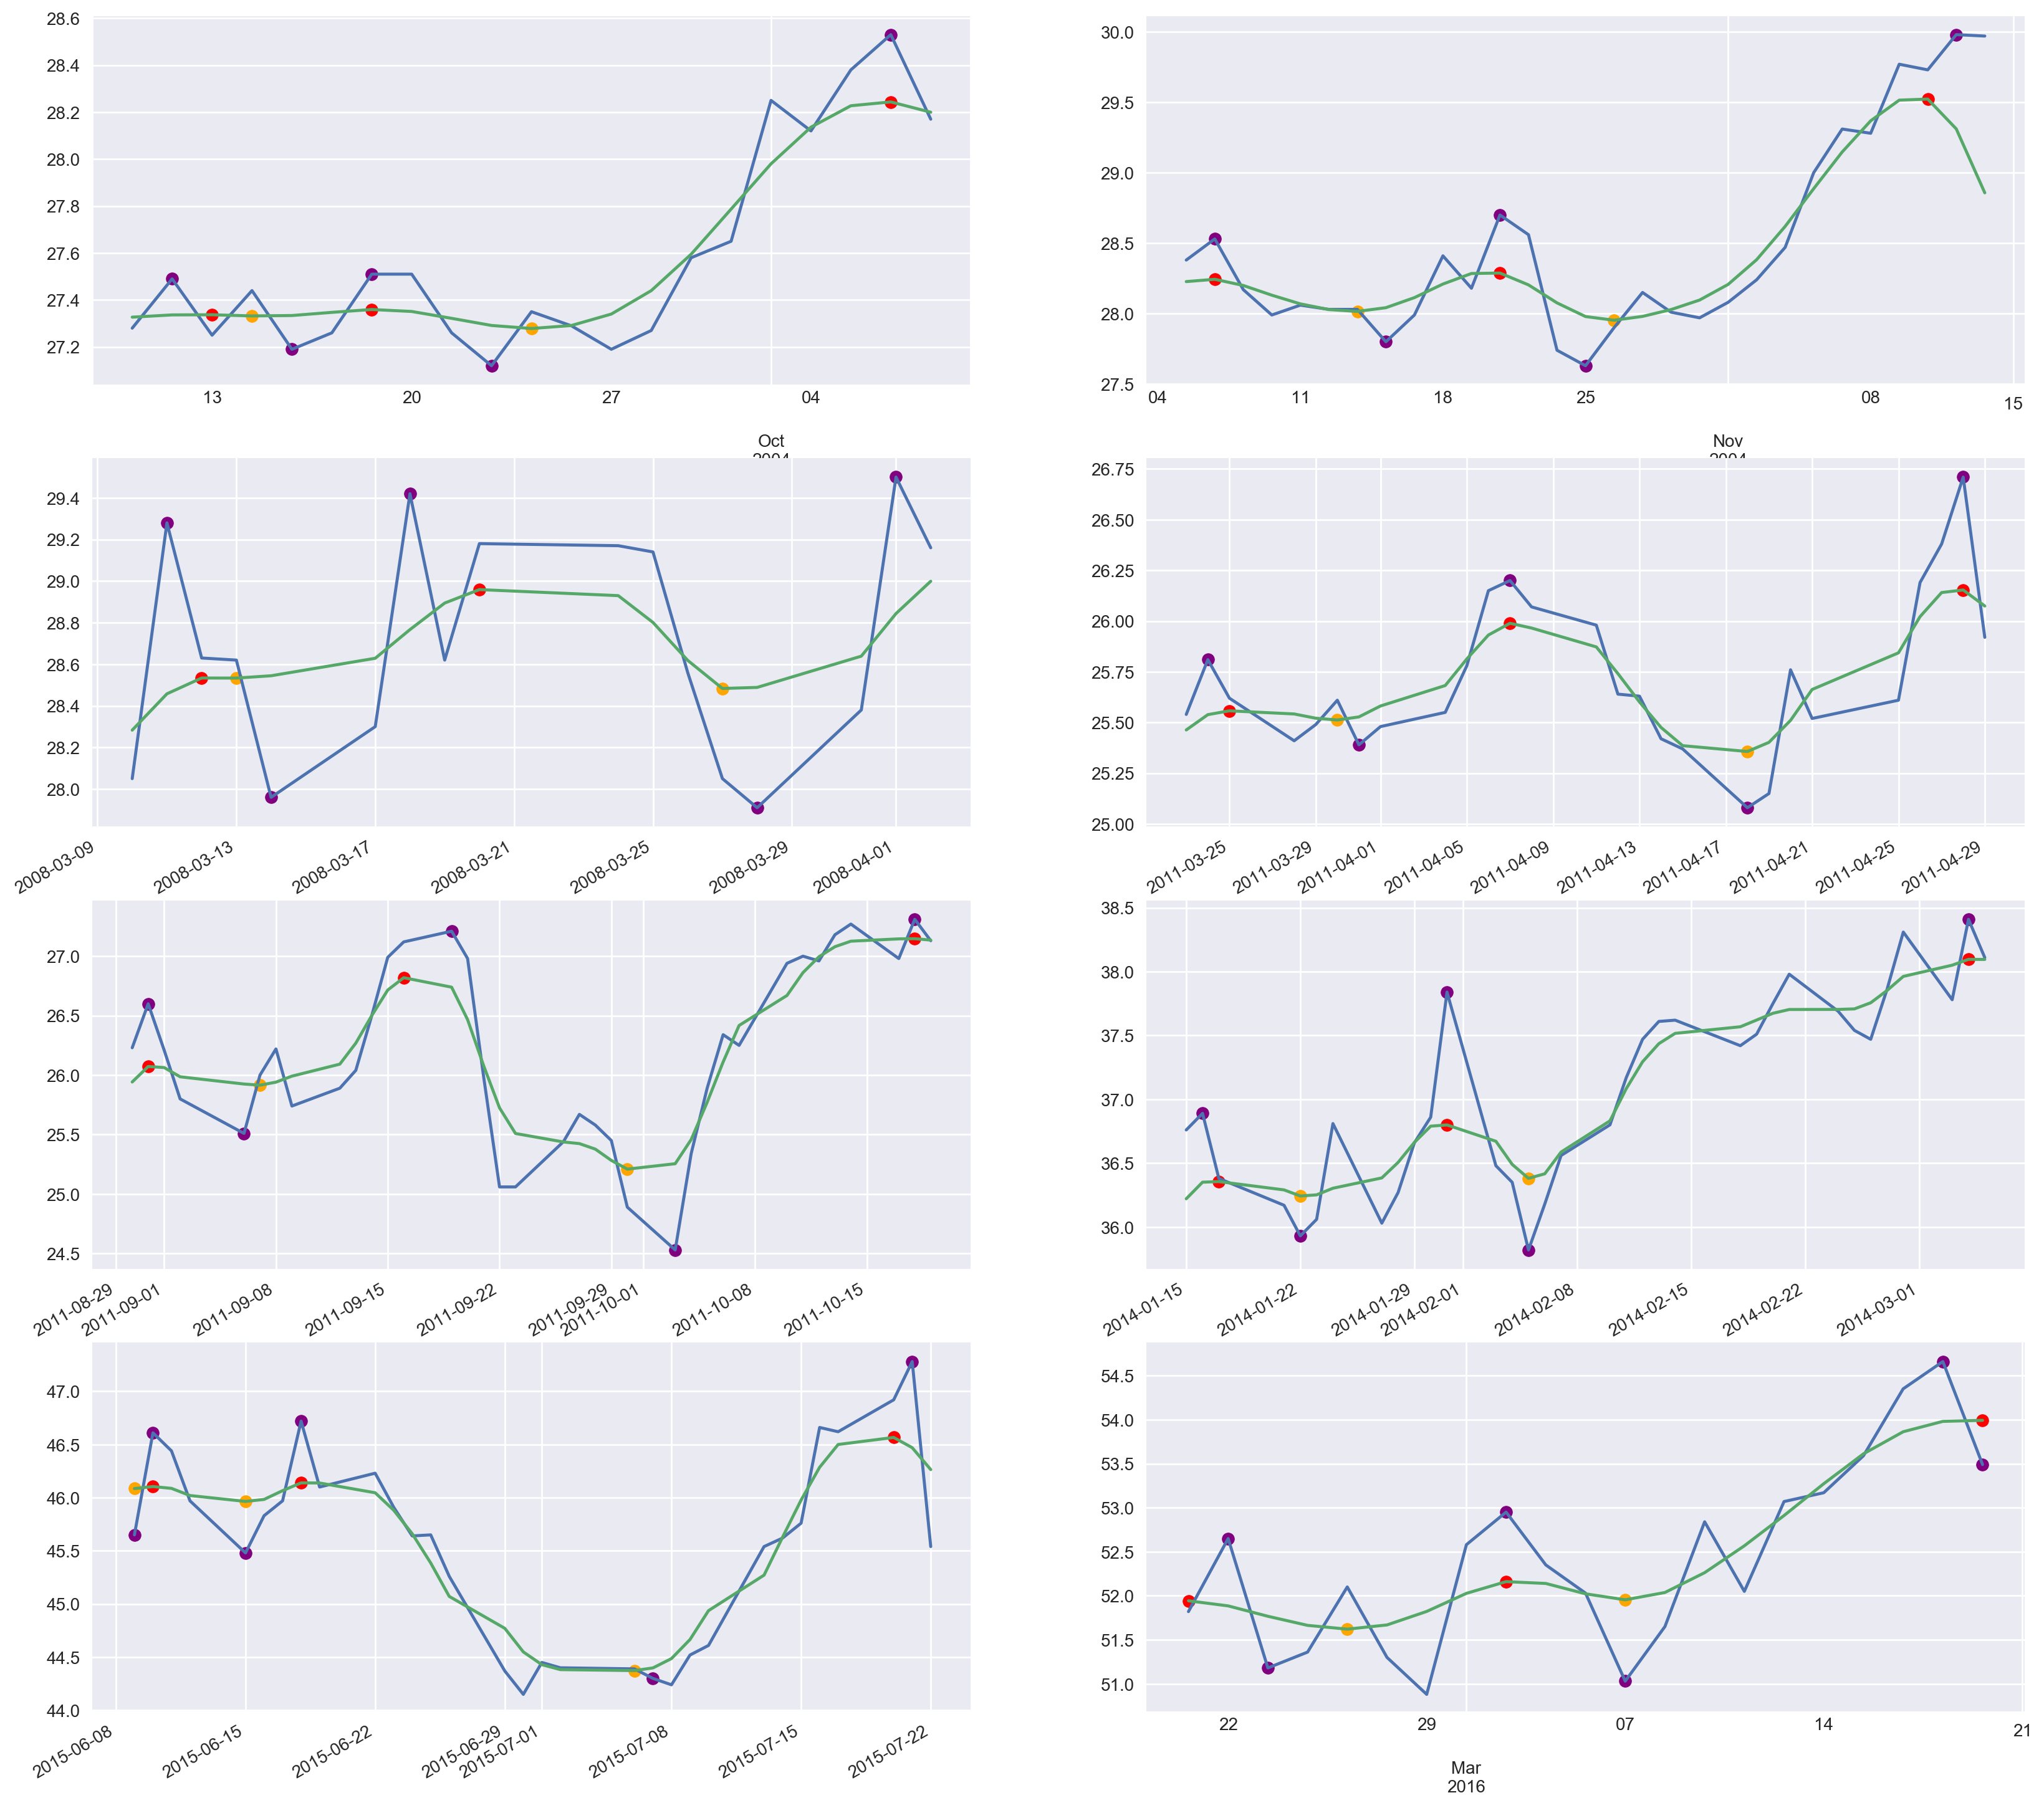

TTOP


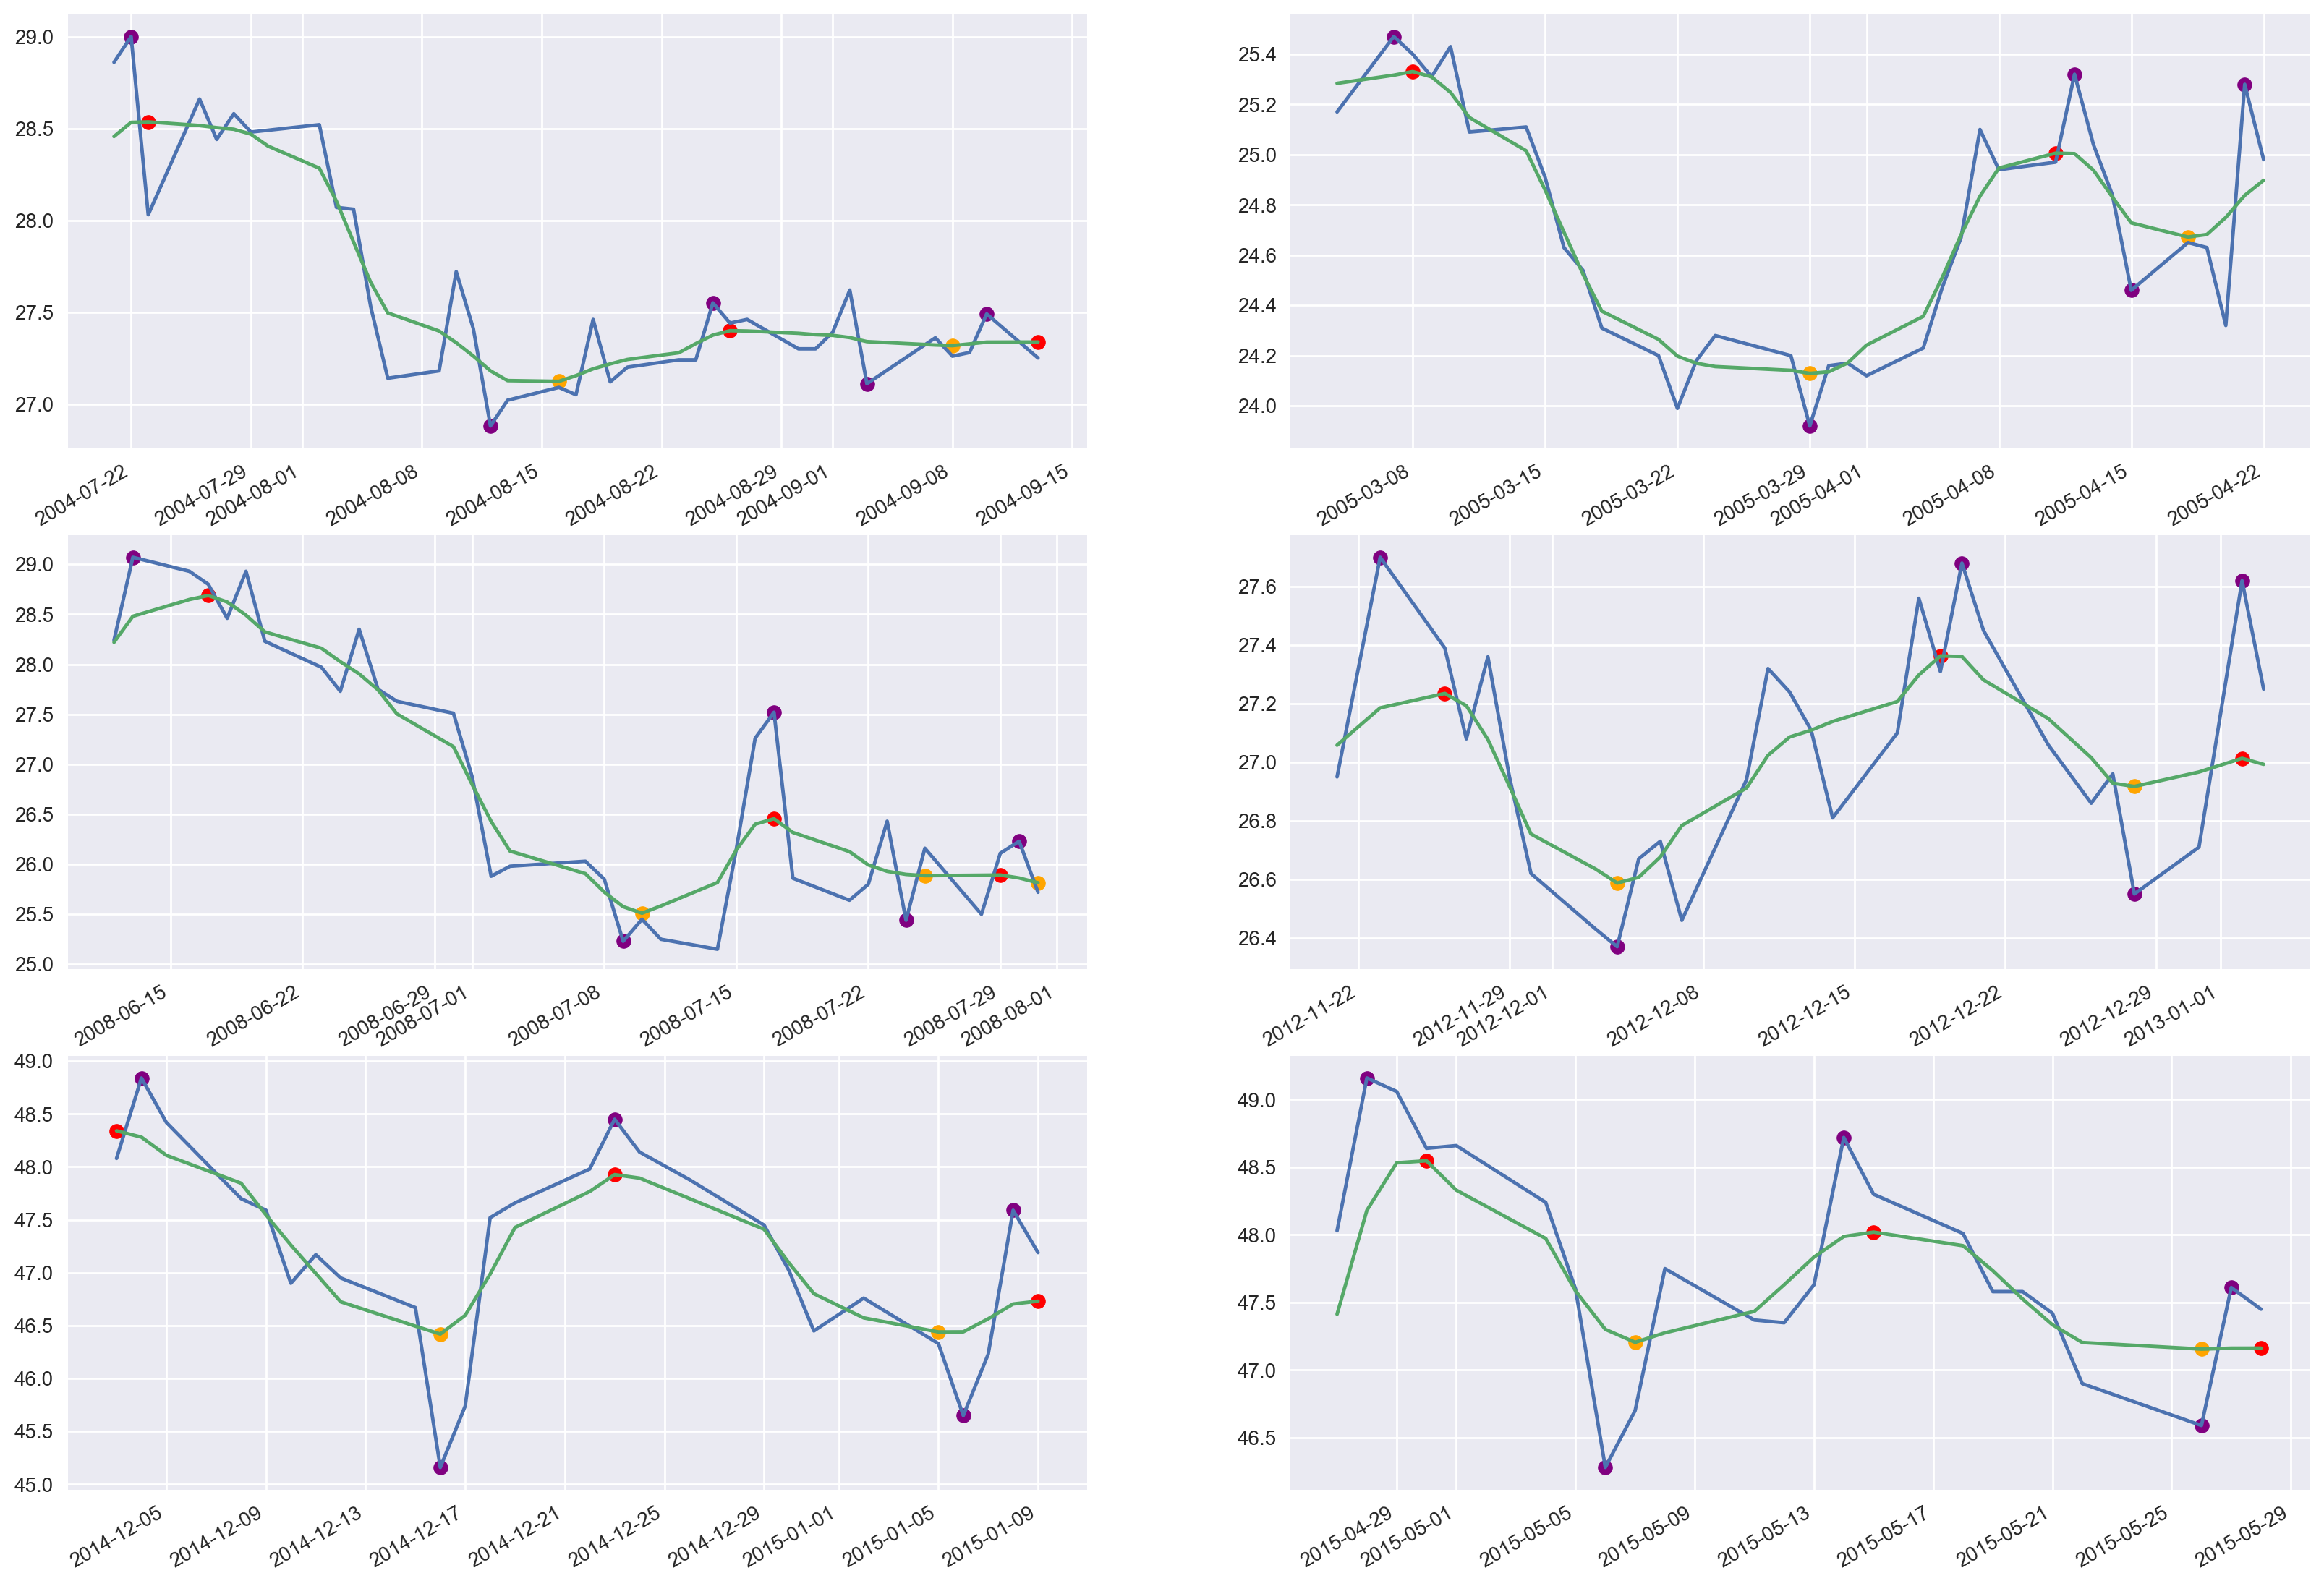

RTOP


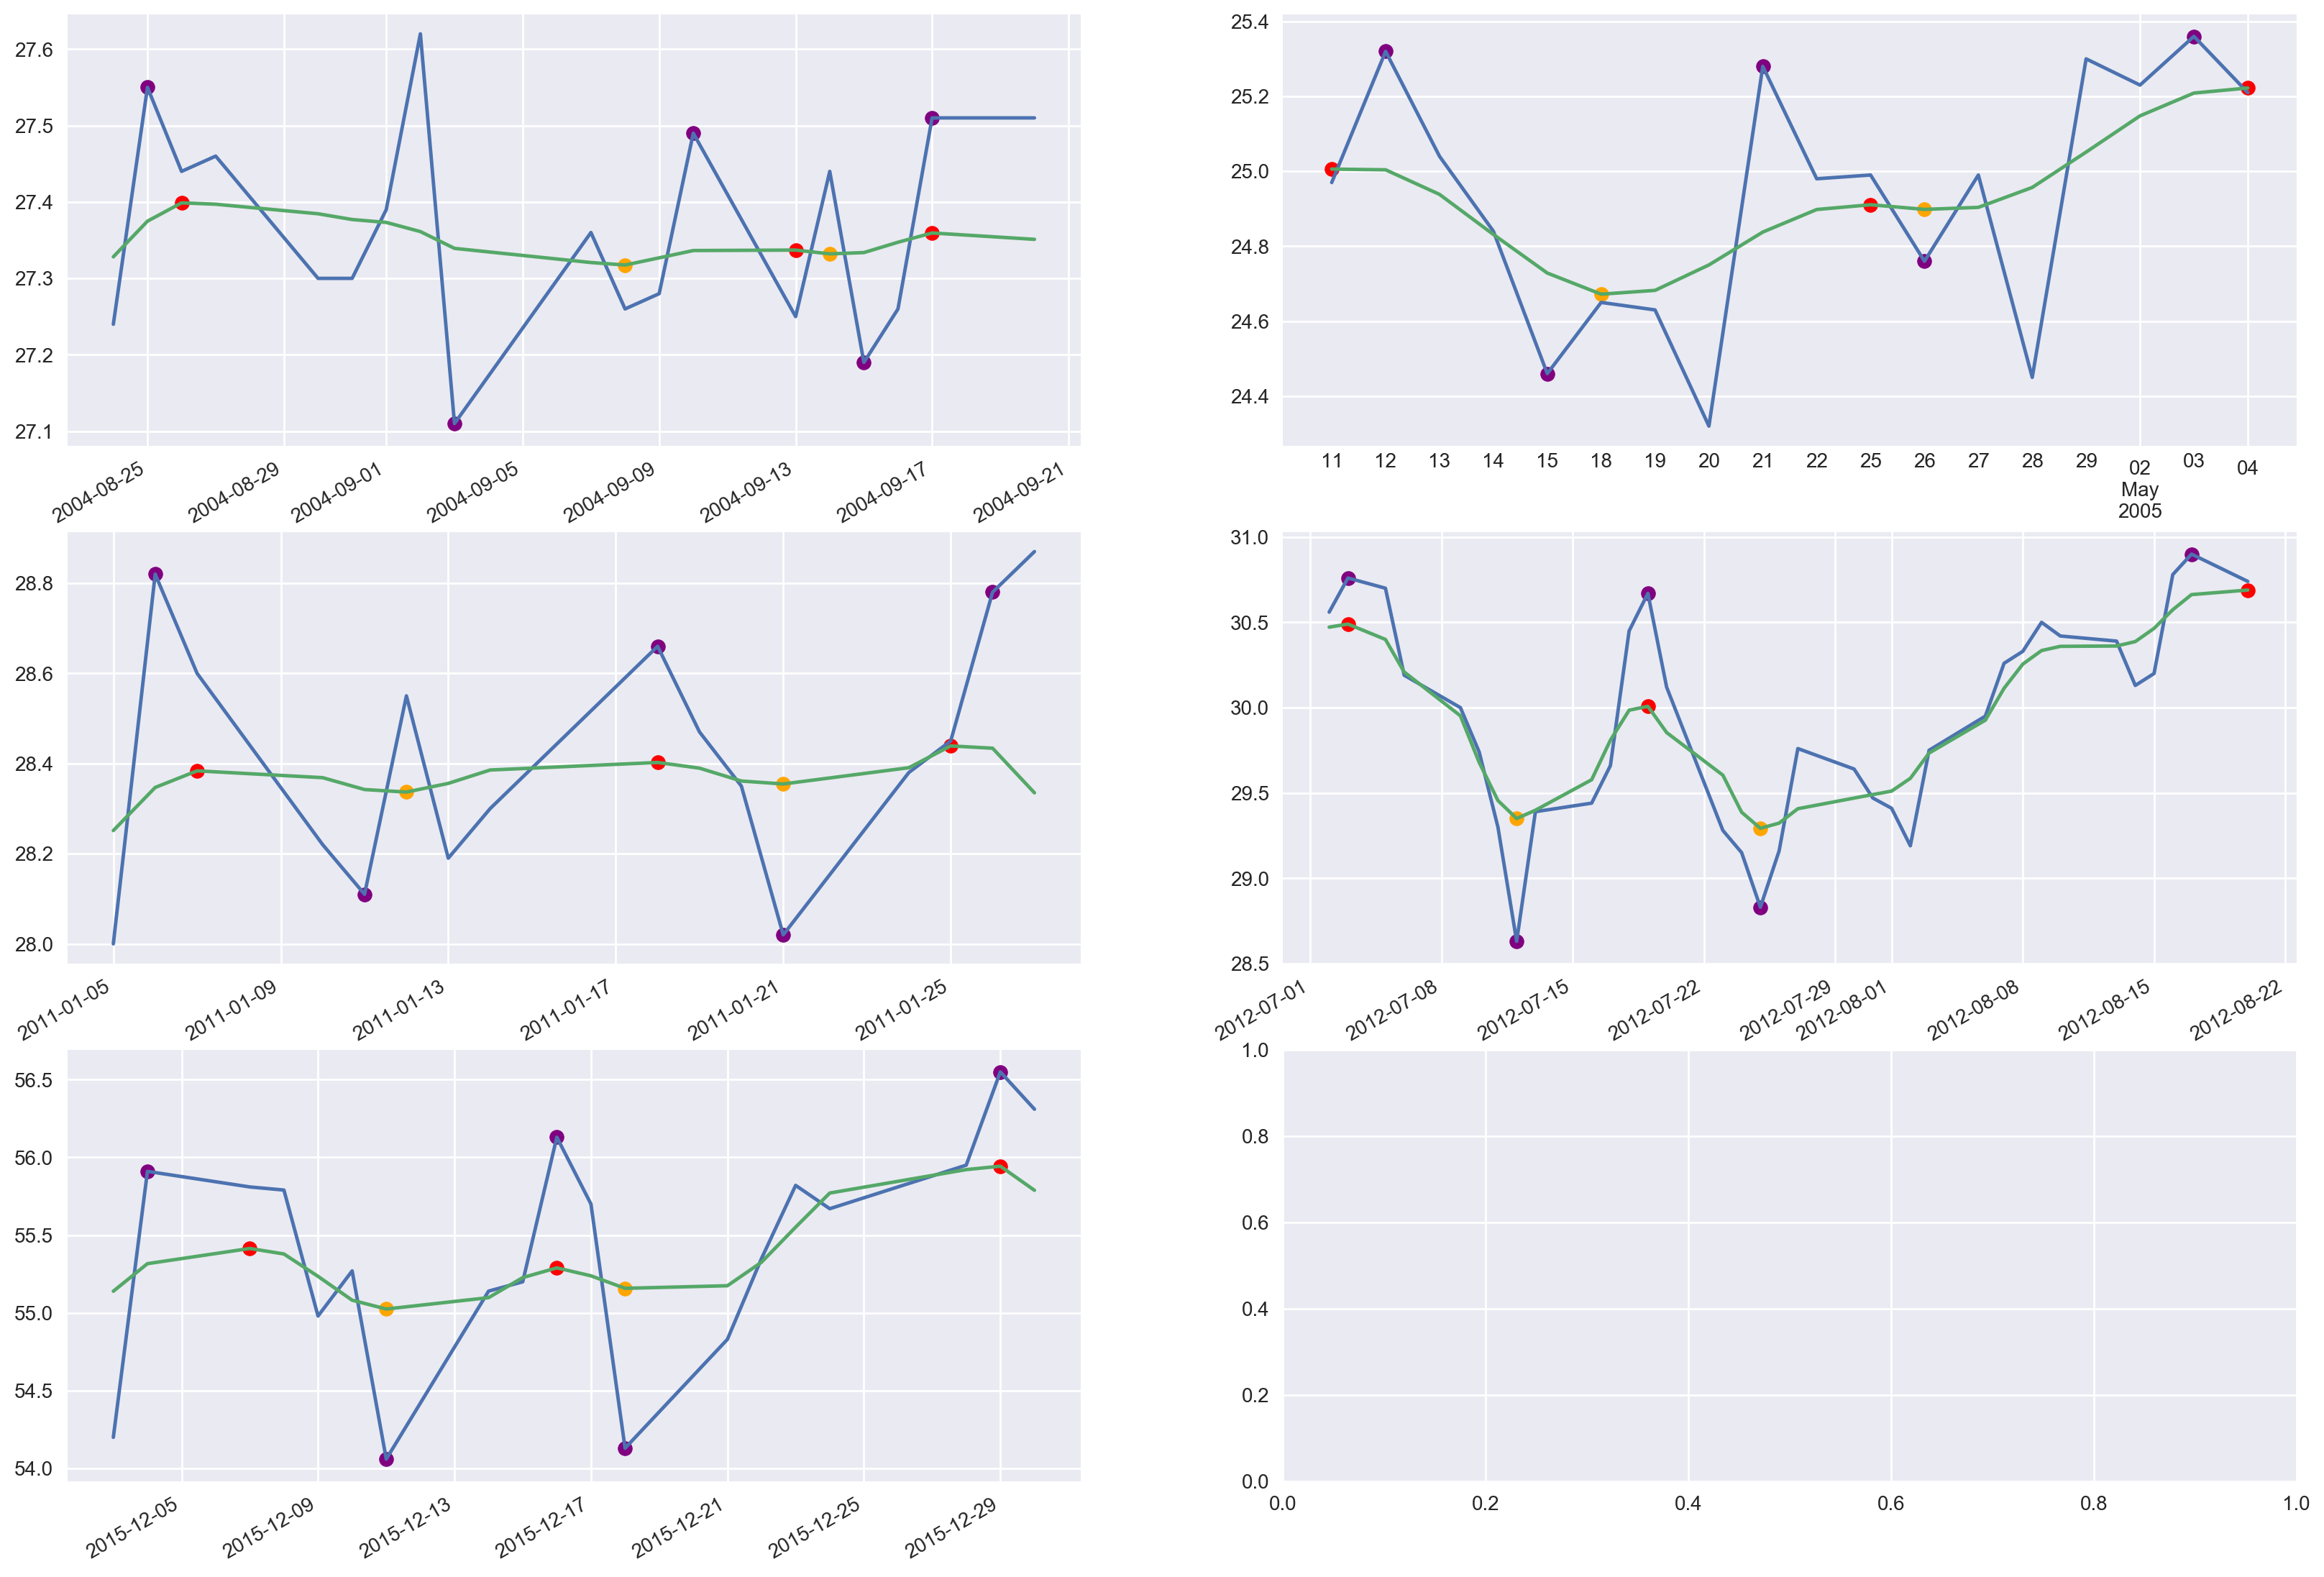

HS


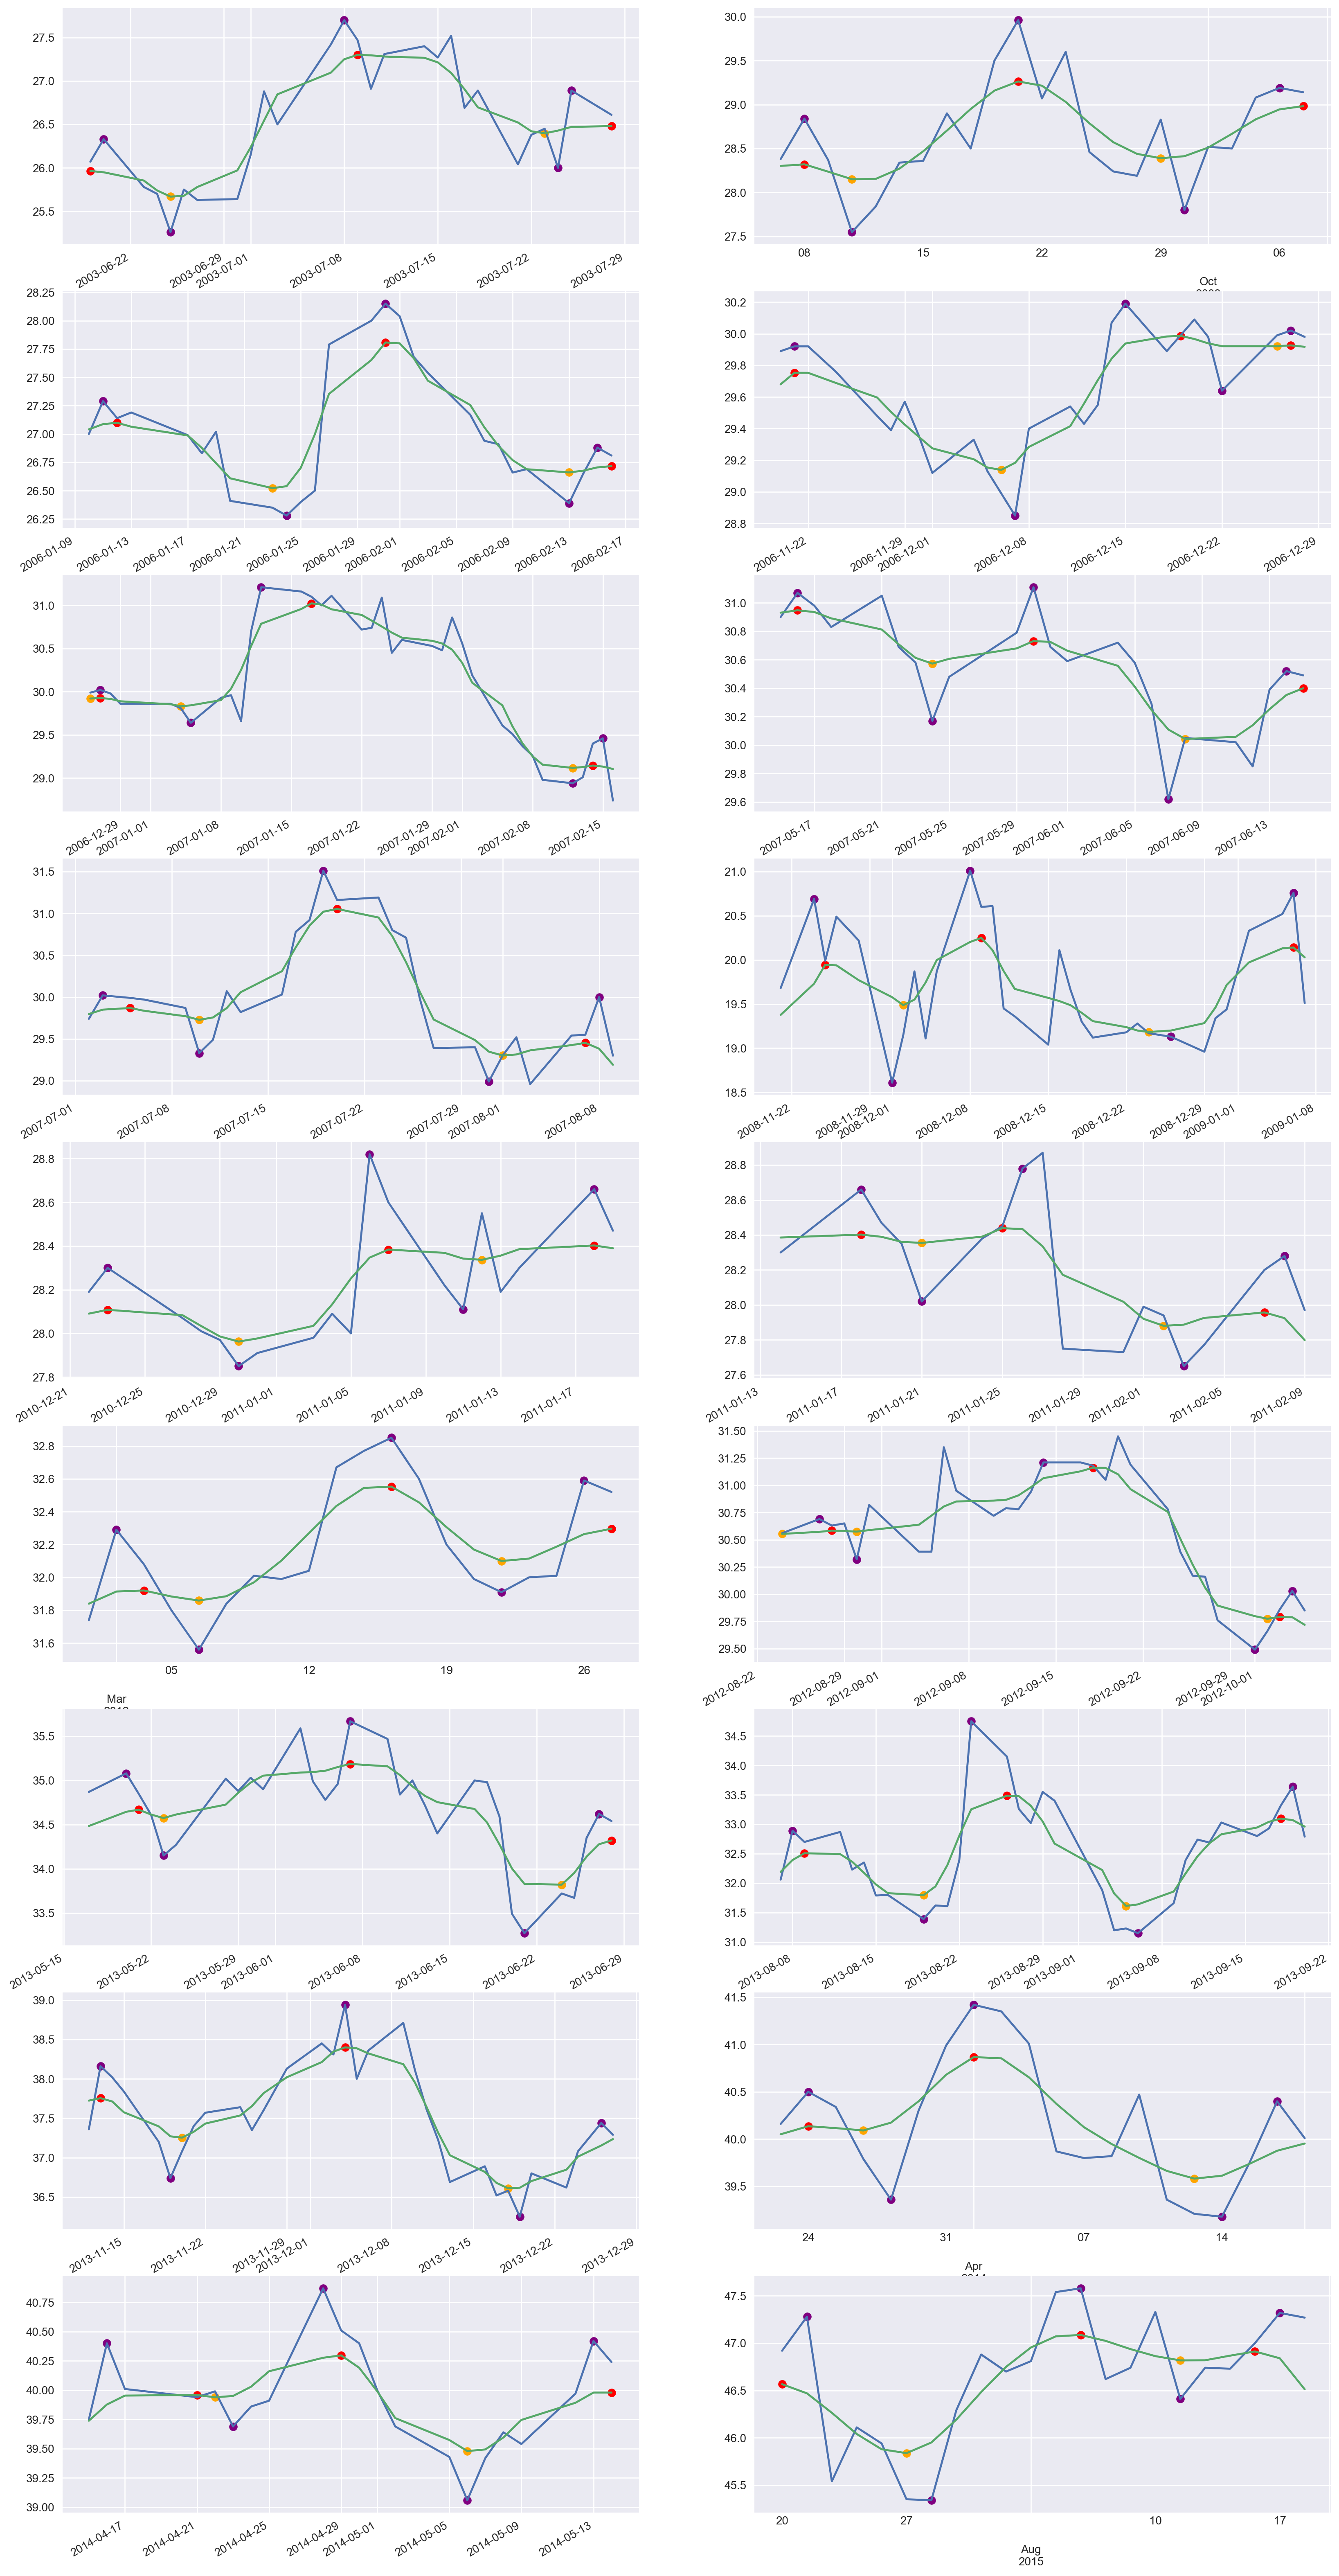

BBOT


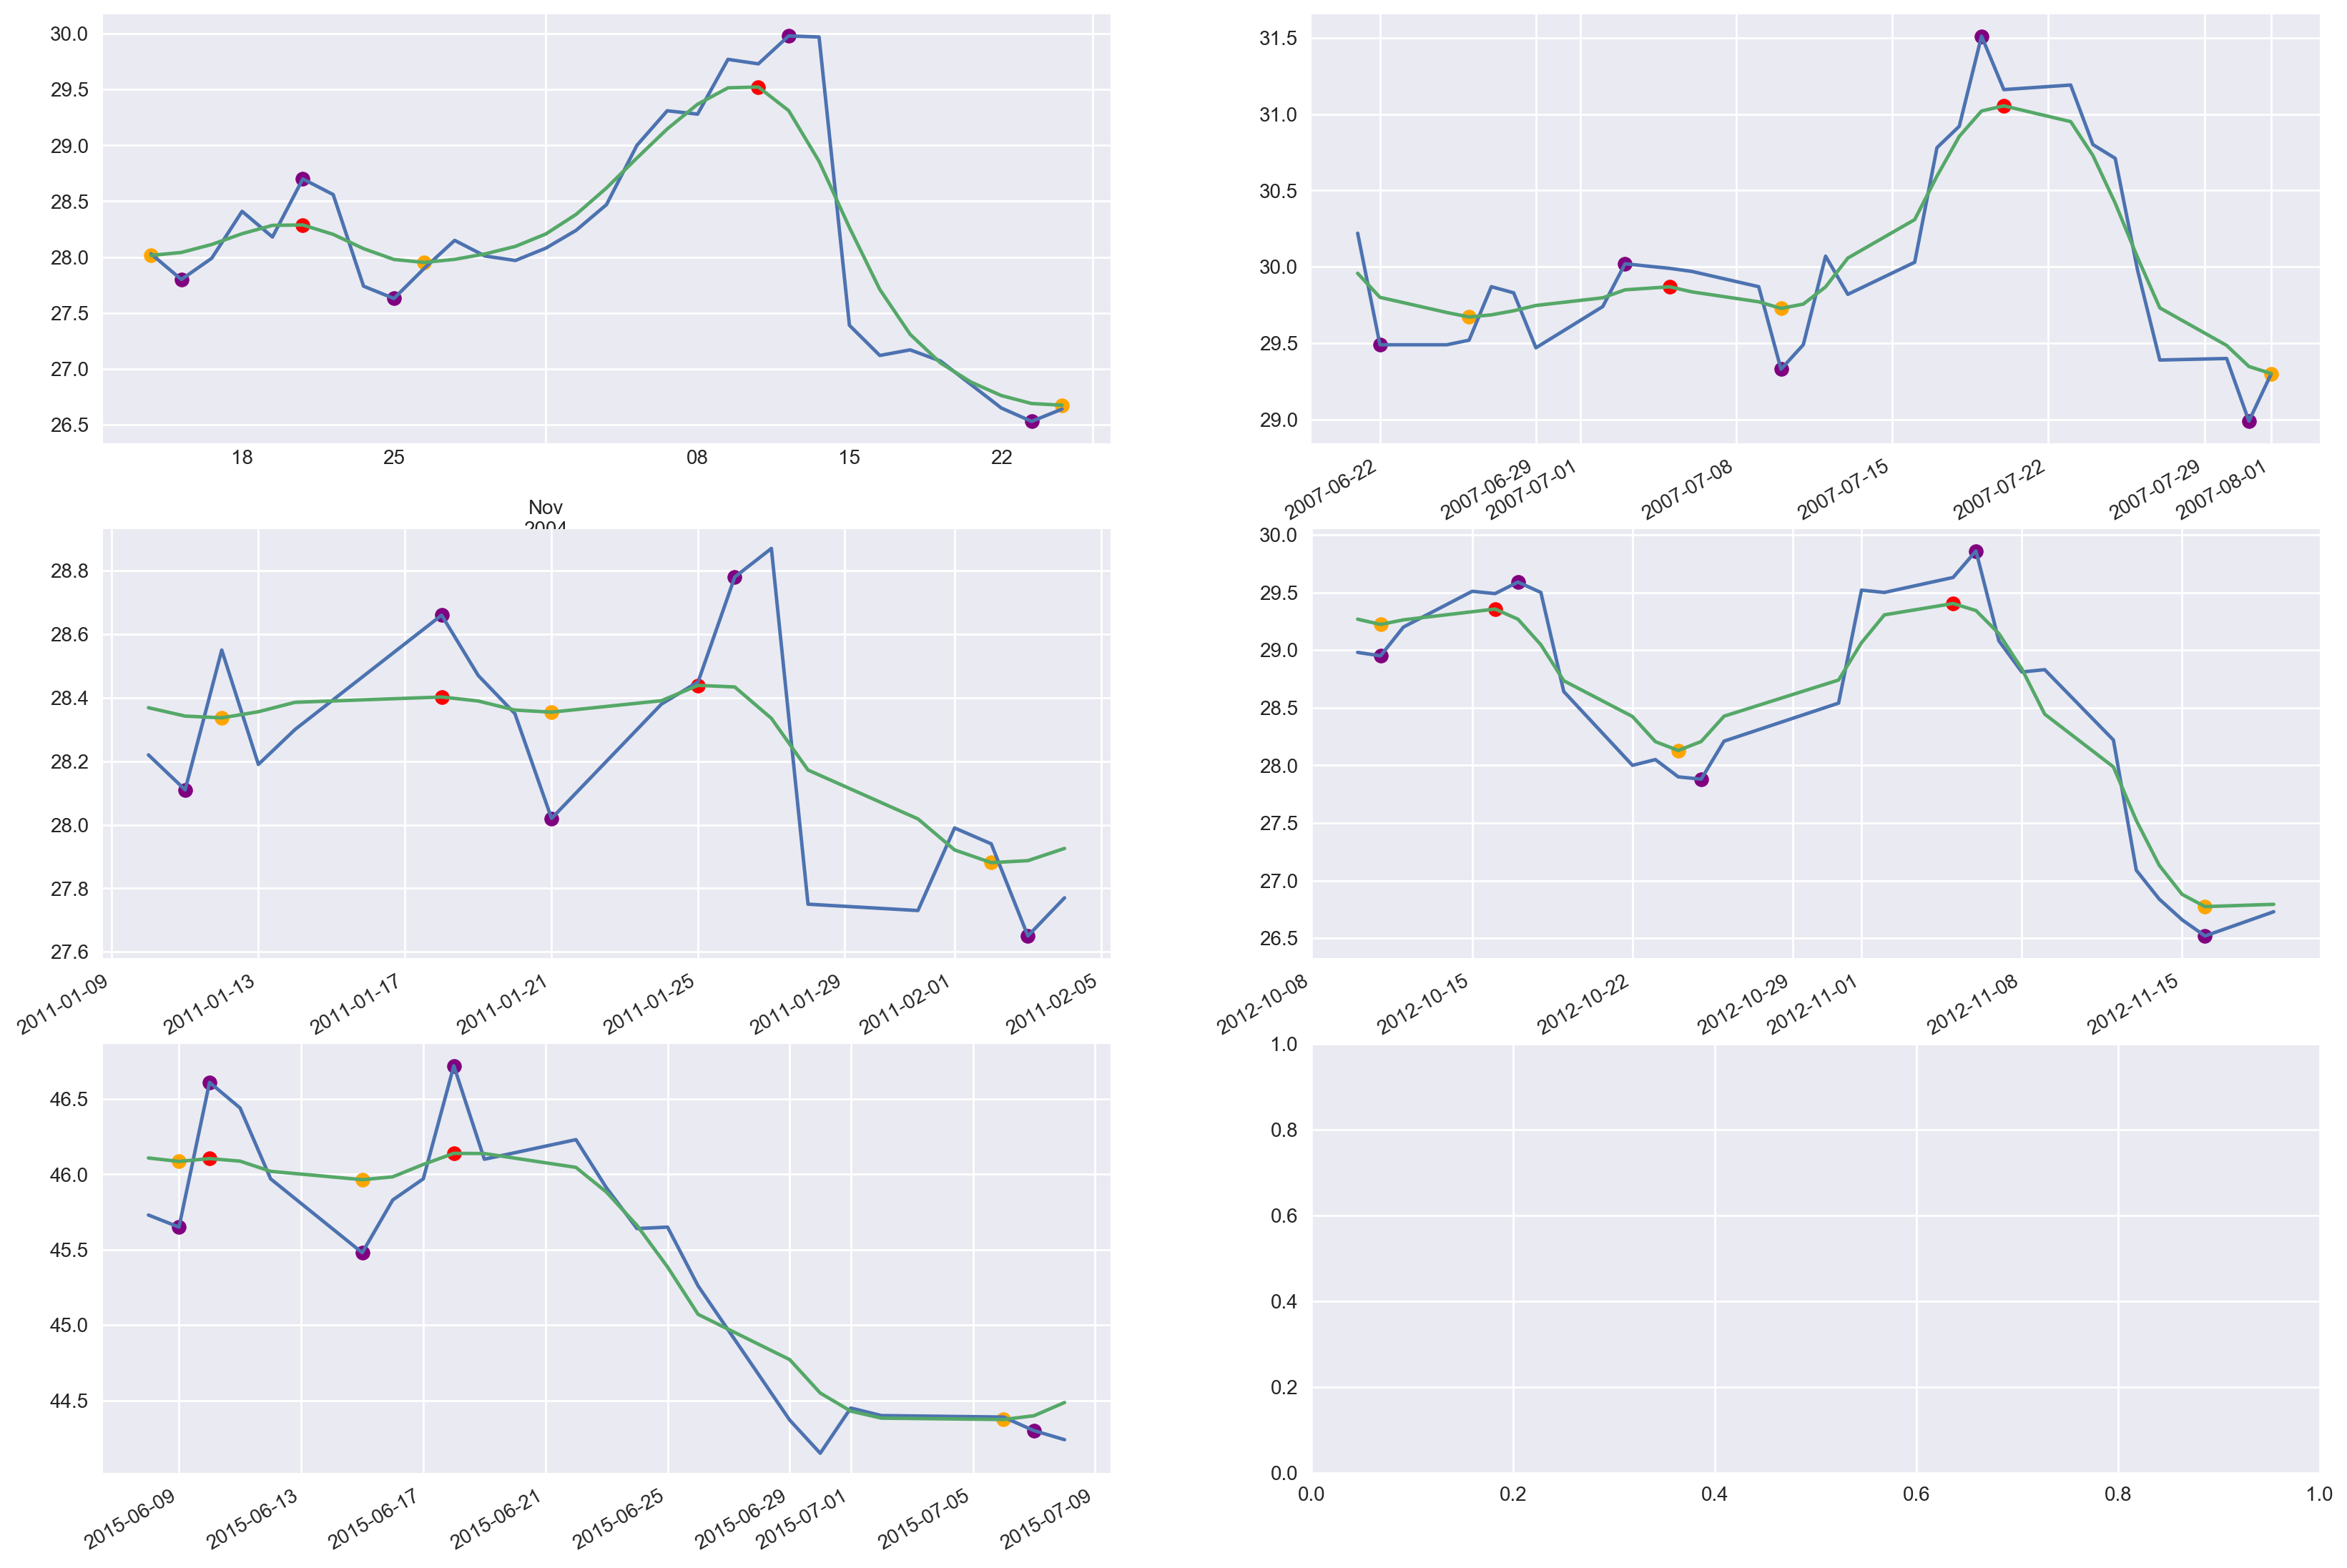

IHS


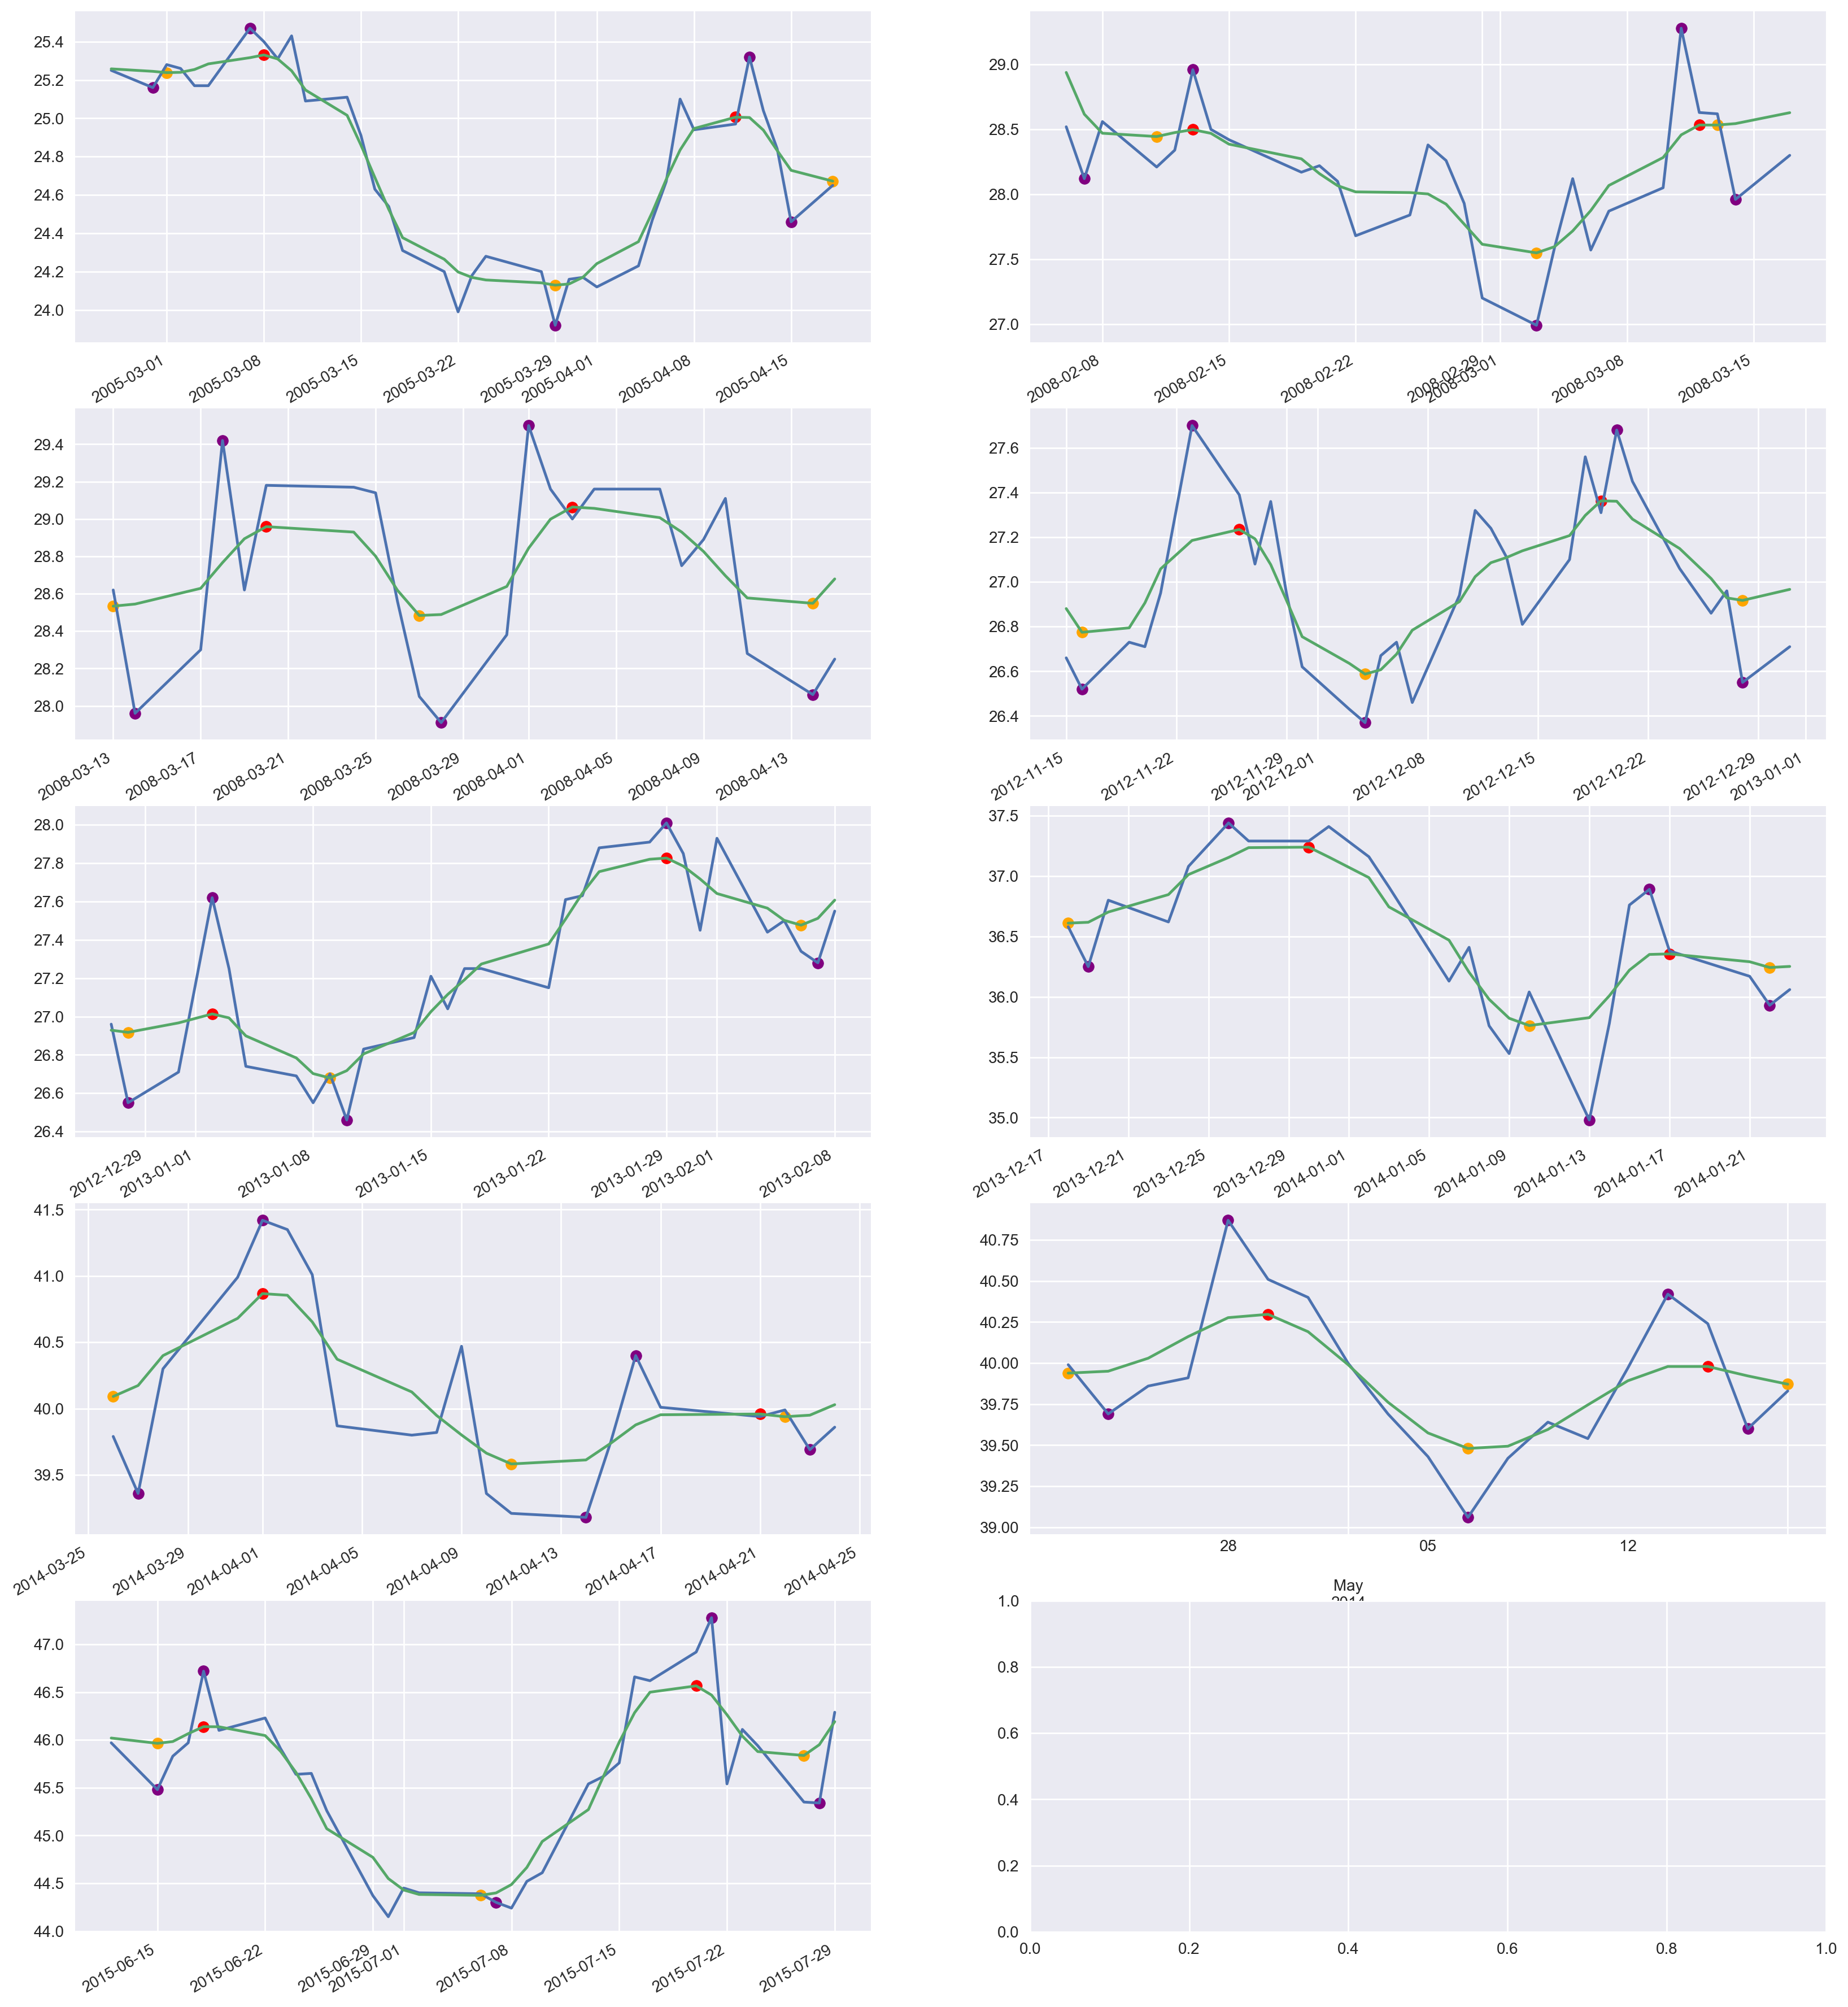

In [50]:
for name, end_day_nums in patterns.items():
    print(name)
    rows = int(np.ceil(len(end_day_nums)/2))
    f, axes = plt.subplots(rows,2, figsize=(20,5*rows))
    axes = axes.flatten()
    i = 0
    for sd, ed in end_day_nums:
        s = msft_prices.index[sd-1]
#         s= np.datetime64(pd.to_datetime(msft_prices.index[sd-1]).strftime('%Y-%m-%d'))
        e = msft_prices.index[ed+1]
#         e= np.datetime64(pd.to_datetime(msft_prices.index[ed+1]).strftime('%Y-%m-%d'))
        plot_window(msft_prices, smooth_prices,pd.to_datetime(local_max_dt), pd.to_datetime(local_min_dt), 
                    pd.to_datetime(price_local_max_dt), pd.to_datetime(price_local_min_dt), s, e, ax=axes[i])
        i+=1
    plt.show()


**Ocurrence of each pattern**

In [51]:
for name, end_day_nums in patterns.items():
    print("{}: {} occurences".format(name, len(end_day_nums)))

TBOT: 8 occurences
BTOP: 8 occurences
TTOP: 6 occurences
RTOP: 5 occurences
HS: 18 occurences
BBOT: 5 occurences
IHS: 9 occurences


# Predictive Power of Technical Patterns

Next, we want to know if our technical patterns can predict forward returns. The proported return sign predicted by each of the patterns is as follows:

Bullish:
- Inverse Head and Shoulders
- Broadening Bottom 
- Rectangle Bottom
- Triangle Bottom

Bearish:
- Head and Shoulders
- Broadening Top
- Rectangle Top
- Triangle Top

Following the authors, I account for a 4 day "observation lag" before the computing the forward return. This lag makes sense, as you would not know a point is a local max/min until the days after it has been observed. 

I also follow the authors by normalizing forward returns.

In [52]:
def compute_pattern_returns(prices, indentification_lag=4):
    max_min = find_max_min(prices)
    patterns = find_patterns(max_min)
    returns = (prices.pct_change(1)
                          .shift(-1)
                          .reset_index(drop=True)
                          .dropna())

    demeaned_returns = (returns - returns.mean()) / returns.std()

    pattern_mean_returns = pd.Series()
    for name, start_end_day_nums in patterns.items():
        if not isinstance(start_end_day_nums, list):
            end_day_nums = [end_day_nums]
        lagged_end_days = map(lambda x: x[1] + indentification_lag, start_end_day_nums)
        pattern_mean_returns[name] = demeaned_returns.loc[lagged_end_days].mean()
    
    return pattern_mean_returns
        

In [175]:
compute_pattern_returns(msft_prices)

TBOT    0.003854
BTOP   -0.259784
TTOP    0.100578
RTOP   -0.262654
HS     -0.181457
BBOT   -0.131439
IHS     0.096919
dtype: float64

Now let't try all this out on a larger universe of stocks. I use pipeline to grab a universe of 500 highly liquid stocks. 

In [ ]:
from zipline.pipeline import Pipeline
from zipline.pipeline import CustomFactor
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.factors import Latest


### Function to download daily stock data from yahoofinance api and save it to a csv

In [290]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    #print(df)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date));

### Fetching S&P 500 stocks list from wikipedia

In [292]:
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.strip('\n')
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

tickers= save_sp500_tickers()

Cleaning the tickers, as few of them showed error in downloading the data from yahoo finance api

In [293]:
tickers= [x for x in tickers if ".B" not in x]
tickers

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BDX',
 'BBY',
 'BIIB',
 'BLK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'CXO',
 'COP',
 'ED',
 '

The start and end dates for our analysis

In [274]:
text_start_date= '2017-01-01'
text_end_date= '2017-12-31'

# Loading Data with Zipline

Before we build our pipeline with Zipline, we will first see how we can load the stock data we are going to use into Zipline. Zipline uses **Data Bundles** to make it easy to use different data sources. A data bundle is a collection of pricing data, adjustment data, and an asset database. Zipline employs data bundles to preload data used to run backtests and store data for future runs. Zipline comes with a few data bundles by default but it also has the ability to ingest new bundles. The first step to using a data bundle is to ingest the data. Zipline's ingestion process will start by downloading the data or by loading data files from your local machine. It will then pass the data to a set of writer objects that converts the original data to Zipline’s internal format (`bcolz` for pricing data, and `SQLite` for split/merger/dividend data) that hs been optimized for speed. This new data is written to a standard location that Zipline can find. By default, the new data is written to a subdirectory of `ZIPLINE_ROOT/data/<bundle>`, where `<bundle>` is the name given to the bundle ingested and the subdirectory is named with the current date. This allows Zipline to look at older data and run backtests on older copies of the data. Running a backtest with an old ingestion makes it easier to reproduce backtest results later. 

In this notebook, we will be downloading csv data, registering its bundle using `bundles.register` and then loading it bundle using `bundle.load()`.
First, we need to specify the name of the bundle to be created. In this case, `european`:

In [ ]:
bundle_name= 'european'

### Downloading all the S&P500 stocks data and storing them in a csv under european/daily directory

CARR failed
CTVA failed
DOW failed
FOXA failed
FOX failed
HWM failed
NLOK failed
OTIS failed
VIAC failed


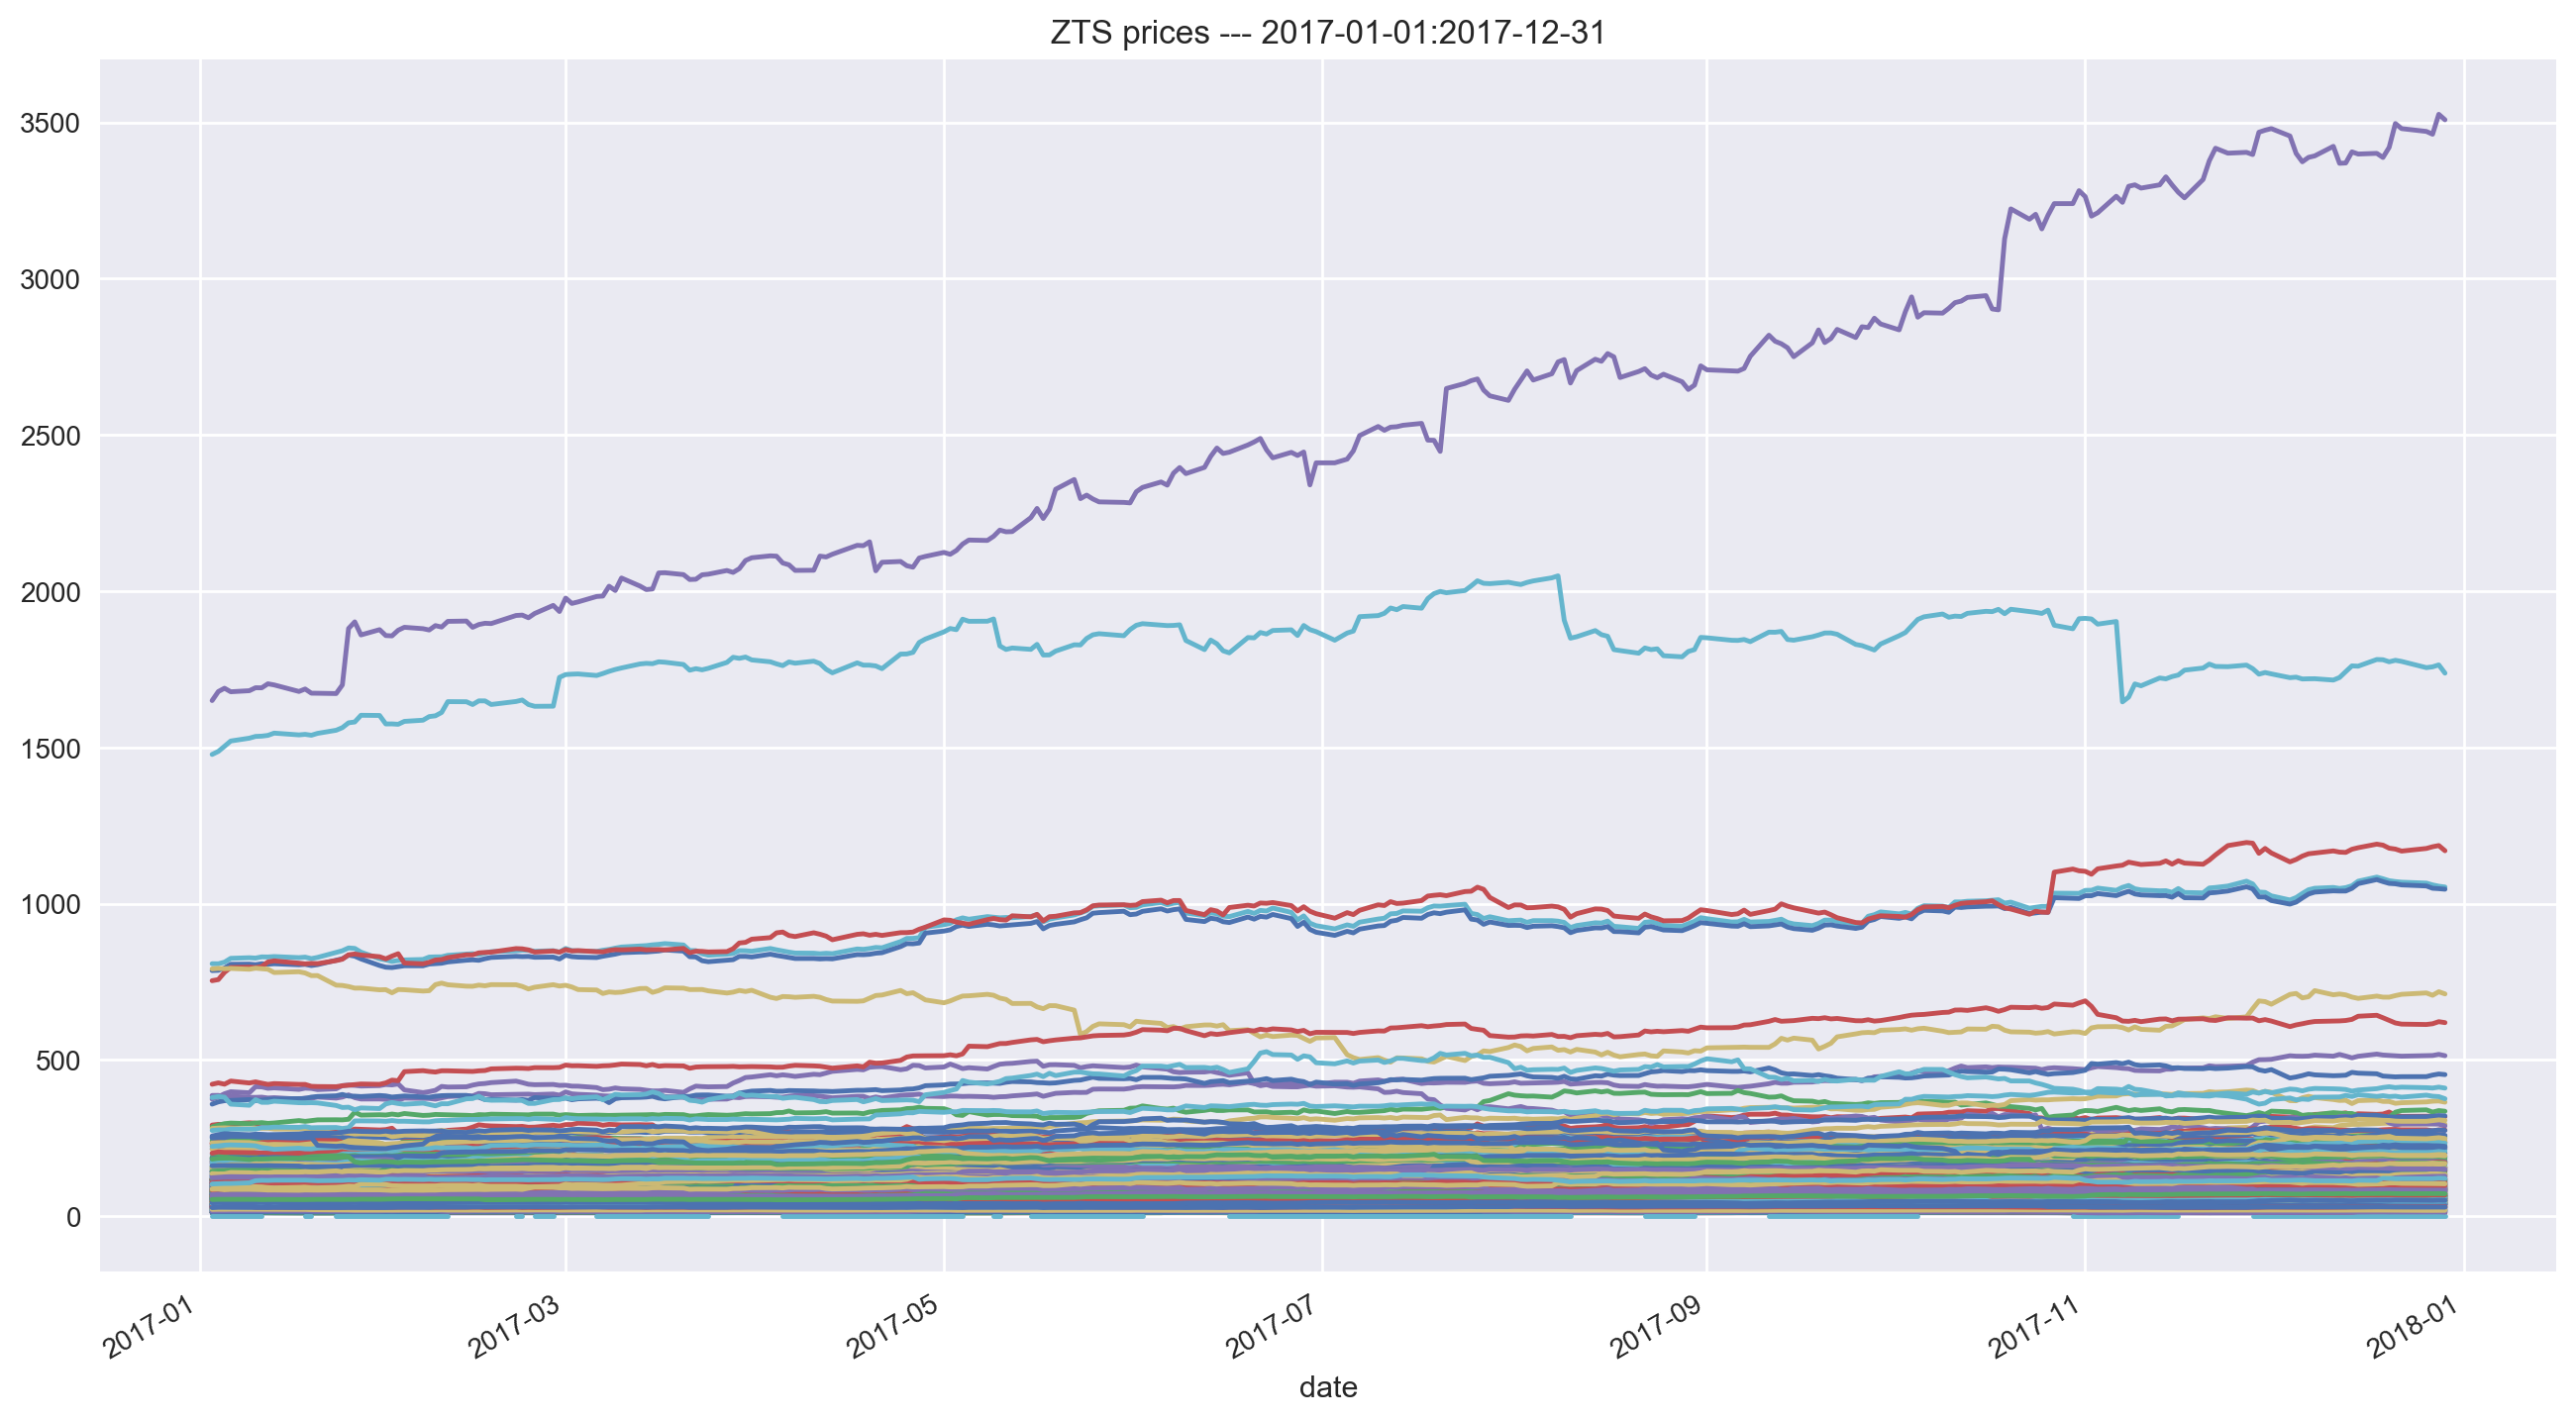

In [295]:
tickers=tickers
# tickers= ['AAPL', 'MSFT']

for ticker in tickers:
    try:
        download_csv_data(ticker=ticker, 
                          start_date=text_start_date, 
                          end_date=text_end_date, 
                          freq='daily', 
                          path=bundle_name+'/daily/'+ticker.strip(' .^')+'.csv')
    except:
        print(ticker+ " failed")

    df=None

Second, we need to register the data bundle and its ingest function with Zipline, using the `bundles.register()` function. The ingest function is responsible for loading the data into memory and passing it to a set of writer objects provided by Zipline to convert the data to Zipline’s internal format. Since the original data was contained in `.csv` files, we will use the `csvdir_equities()` function to generate the ingest function for our data bundle. In addition, since european's `.csv` files contained daily stock data, we will set the time frame for our ingest function, to `daily`.

In [ ]:
from yahoofinancials import YahooFinancials
from zipline.data import bundles
from zipline.data.bundles.csvdir import csvdir_equities
import os

#Changing current zipline root to bundle_name
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), bundle_name)

# Create an ingest function 
ingest_func = csvdir_equities(['daily'], os.environ['ZIPLINE_ROOT'])

# Register the data bundle and its ingest function
bundles.register(bundle_name, ingest_func);


After registering bundlename, we need to ingest the bundle. The ingestion process will invoke some custom bundle command and then write the data to a standard location that zipline can find. By default the location where ingested data will be written is `$ZIPLINE_ROOT/data/<bundle>` where by default `ZIPLINE_ROOT=~/.zipline`. The ingestion step may take some time as it could involve downloading and processing a lot of data. We've changed our zipline root to `os.environ['ZIPLINE_ROOT']/<bundle_name>/daily`

In [281]:
# Whatever csv are the under os.environ['ZIPLINE_ROOT']/<bundle_name>/daily those would be ingested
bundles.ingest(bundle_name)

 | A: sid 0
 | AAL: sid 1
 | AAP: sid 2
 | AAPL: sid 3
 | ABBV: sid 4
 | ABC: sid 5
 | ABMD: sid 6
 | ABT: sid 7
 | ACN: sid 8
 | ADBE: sid 9
 | ADI: sid 10
 | ADM: sid 11
 | ADP: sid 12
 | ADS: sid 13
 | ADSK: sid 14
 | AEE: sid 15
 | AEP: sid 16
 | AES: sid 17
 | AFL: sid 18
 | AIG: sid 19
 | AIV: sid 20
 | AIZ: sid 21
 | AJG: sid 22
 | AKAM: sid 23
 | ALB: sid 24
 | ALGN: sid 25
 | ALK: sid 26
 | ALL: sid 27
 | ALLE: sid 28
 | ALXN: sid 29
 | AMAT: sid 30
 | AMCR: sid 31
 | AMD: sid 32
 | AME: sid 33
 | AMGN: sid 34
 | AMP: sid 35
 | AMT: sid 36
 | AMZN: sid 37
 | ANET: sid 38
 | ANSS: sid 39
 | ANTM: sid 40
 | AON: sid 41
 | AOS: sid 42
 | APA: sid 43
 | APD: sid 44
 | APH: sid 45
 | APTV: sid 46
 | ARE: sid 47
 | ATO: sid 48
 | ATVI: sid 49
 | AVB: sid 50
 | AVGO: sid 51
 | AVY: sid 52
 | AWK: sid 53
 | AXP: sid 54
 | AZO: sid 55
 | BA: sid 56
 | BAC: sid 57
 | BAX: sid 58
 | BBY: sid 59
 | BDX: sid 60
 | BIIB: sid 61
 | BK: sid 62
 | BKNG: sid 63
 | BKR: sid 64
 | BLK: sid 65
 | 

Once our data bundle and ingest function are registered, we can load our data using the `bundles.load()` function.

In [128]:
bundle_data = bundles.load(bundle_name)

One of the design ideas for Pipeline is separating an abstract description of a dataset from a concrete source for that dataset.  We achieve that separation by distinguishing between DataSets and **loaders** for those datasets.  DataSets are just abstract collections of sentinel values describing the columns/types for a dataset.  A loader is an object which, given a request for a particular chunk of a dataset, can actually produce the requested data.  We associate loaders with datasets by passing a dispatching function to SimplePipelineEngine (https://github.com/quantopian/zipline/blob/master/zipline/pipeline/engine.py).

The loader used on the Quantopian platform for USEquityPricing, is the USEquityPricingLoader class defined in https://github.com/quantopian/zipline/blob/master/zipline/pipeline/loaders/equity_pricing_loader.py.  It, in turn, mostly delegates to lower-level subsystems that know how to fetch pricing data in the default formats used by Zipline (bcolz for pricing data, and SQLite for split/merger/dividend data).  You could get data in these formats by using (or implementing) a zipline bundle, as described in (http://www.zipline.io/bundles.html#discovering-available-bundles).  

Note that while USEquityPricingLoader only knows how to load the USEquityPricing dataset, it's perfectly possible to write a different loader for the same dataset and use that loader instead (we do this in many places in Zipline's test suite).
From a Pipeline API perspective, there's nothing essential about the bcolz format for pricing data other than that it's what we use for Quantopian and it's been pretty well-optimized for speed.

There are lots of other loaders defined in https://github.com/quantopian/zipline/tree/master/zipline/pipeline/loaders, including, for example, a loader that can just take a pandas DataFrame (https://github.com/quantopian/zipline/blob/master/zipline/pipeline/loaders/frame.py), which might be useful if your dataset is small enough to hold in RAM all at once.

One particularly powerful family of loaders lives in zipline.pipeline.loaders.blaze, and uses Blaze (http://blaze.readthedocs.io/en/latest/index.html) to automatically generate datasets and loaders for any kind of "morally tabular" data.  We use blaze loaders on Quantopian to load data from a variety of sources, including SQL databases, in-memory dataframes, and from HDF5 files.  There's a fairly lengthy description of how the blaze loader works at the top of `zipline/pipeline.loaders/blaze/core.py`.

In [129]:
from zipline.pipeline.loaders import USEquityPricingLoader
# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader)

Ref
[https://www.quantopian.com/tutorials/pipeline#lesson3](https://www.quantopian.com/tutorials/pipeline#lesson3)

[https://www.quantopian.com/tutorials/pipeline#lesson10](https://www.quantopian.com/tutorials/pipeline#lesson10) 

In Pipeline, Factors are the most commonly-used term, representing the result of any computation producing a numerical result. Factors require a column of data as well as a window length as input. Zipline provides built-in factors like SimpleMovingAverage, 
A custom factor is identical to a built-in factor. It accepts inputs, window_length, and mask as constructor arguments, and returns a Factor object each day. 

Here our custom factor determines liquidity. i.e. select only those stocks whose `volume*close < 500.`

In [286]:
from zipline.pipeline.data import USEquityPricing


class Liquidity(CustomFactor):   
    inputs = [USEquityPricing.volume, USEquityPricing.close] 
    window_length = 5

    def compute(self, today, assets, out, volume, close): 
        out[:] = (volume * close).mean(axis=0)
        
liquidity = Liquidity()
liquidity_rank = liquidity.rank(ascending=False)

pipe = Pipeline()
pipe.add(liquidity, 'liquidity')
pipe.set_screen(liquidity_rank < 500)

#conda install python-graphviz
#pipe.show_graph()

# Pipeline Engine

Zipline employs computation engines for executing Pipelines. In the code below we will use Zipline's `SimplePipelineEngine()` class as the engine to execute our pipeline. The `SimplePipelineEngine(get_loader, calendar, asset_finder)` class associates the chosen data loader with the corresponding dataset and a trading calendar. The `get_loader` parameter must be a callable function that is given a loadable term and returns a `PipelineLoader` to use to retrieve the raw data for that term in the pipeline. In our case, we will be using the `pricing_loader` defined above, we therefore, create a function called `choose_loader` that returns our `pricing_loader`. The function also checks that the data that is being requested corresponds to OHLCV data, otherwise it retunrs an error. The `calendar` parameter must be a `DatetimeIndex` array of dates to consider as trading days when computing a range between a fixed `start_date` and `end_date`. In our case, we will be using the same trading days as those used in the NYSE. We will use Zipline's `get_calendar('NYSE')` function to retrieve the trading days used by the NYSE. We then use the `.all_sessions` attribute to get the `DatetimeIndex` from our `trading_calendar` and pass it to the `calendar` parameter. Finally, the `asset_finder` parameter determines which assets are in the top-level universe of our stock data at any point in time. Since we are using the Quotemedia data bundle, we set this parameter to the `bundle_data.asset_finder`.

In [131]:
from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine

# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# Set the trading calendar
trading_calendar = get_calendar('NYSE')

# Create a Pipeline engine
engine = SimplePipelineEngine(get_loader = choose_loader,
                              calendar = trading_calendar.all_sessions,
                              asset_finder = bundle_data.asset_finder)

## Note
**text_start_date variable is different from 2017-1-3 this is the first date from csv files. on the text_start_date the market might be closed. make sure (2017-1-3) these numbers are correct or zipline would throw an error**

### Running a Pipeline

Once we have chosen our engine we are ready to run or execute our pipeline. We can run our pipeline by using the `.run_pipeline()` attribute of the `SimplePipelineEngine` class. In particular, the `SimplePipelineEngine.run_pipeline(pipeline, start_date, end_date)` implements the following algorithm for executing pipelines:


1. Build a dependency graph of all terms in the `pipeline`. In this step, the graph is sorted topologically to determine the order in which we can compute the terms.


2. Ask our AssetFinder for a “lifetimes matrix”, which should contain, for each date between `start_date` and `end_date`, a boolean value for each known asset indicating whether the asset existed on that date.


3. Compute each term in the dependency order determined in step 1, caching the results in a a dictionary so that they can be fed into future terms.


4. For each date, determine the number of assets passing the `pipeline` screen. The sum, $N$, of all these values is the total number of rows in our output Pandas Dataframe, so we pre-allocate an output array of length $N$ for each factor in terms.


5. Fill in the arrays allocated in step 4 by copying computed values from our output cache into the corresponding rows.


6. Stick the values computed in step 5 into a Pandas DataFrame and return it.

In the code below, we run our pipeline for a single day, so our `start_date` and `end_date` will be the same. We then print some information about our `pipeline_output`.

In [228]:
start_date = pd.Timestamp('2017-1-3', tz = 'utc')
end_date = pd.Timestamp('2017-12-29', tz = 'utc')
data = engine.run_pipeline(pipe, start_date=start_date, end_date=end_date)

In [229]:
data


liquidity
2017-01-10 00:00:00+00:00 Equity(0 [A])       9.979687e+07
                          Equity(1 [AAL])     2.914813e+08
                          Equity(2 [AAP])     1.223407e+08
                          Equity(3 [AAPL])    3.223696e+09
                          Equity(4 [ABBV])    4.677764e+08
                          Equity(5 [ABC])     2.191805e+08
                          Equity(6 [ABMD])    3.710339e+07
                          Equity(7 [ABT])     5.586285e+08
                          Equity(8 [ACN])     3.557855e+08
                          Equity(9 [ADBE])    2.562258e+08
                          Equity(10 [ADI])    1.611433e+08
                          Equity(11 [ADM])    1.672507e+08
                          Equity(12 [ADP])    2.134086e+08
                          Equity(13 [ADS])    1.124904e+08
                          Equity(14 [ADSK])   1.281201e+08
                          Equity(15 [AEE])    8.358560e+07
                          Equity(16 [AEP])    1.522577e+08
                          Equity(17 [AES])    6.093422e+07
                          Equity(18 [AFL])    1.477423e+08
                          Equity(19 [AIG])    3.468276e+08
                          Equity(20 [AIV])    4.246436e+07
                          Equity(21 [AIZ])    4.097038e+07
                          Equity(22 [AJG])    5.850620e+07
                          Equity(23 [AKAM])   1.045285e+08
                          Equity(24 [ALB])    8.145120e+07
                          Equity(25 [ALGN])   8.129120e+07
                          Equity(26 [ALK])    1.137428e+08
                          Equity(27 [ALL])    1.350164e+08
                          Equity(28 [ALLE])   5.974016e+07
                          Equity(29 [ALXN])   5.412768e+08
...                                                    ...
2017-12-29 00:00:00+00:00 Equity(56 [BA])     7.049088e+08
                          Equity(57 [BAC])    1.446080e+09
                          Equity(58 [BAX])    1.287009e+08
                          Equity(59 [BBY])    1.325809e+08
                          Equity(60 [BDX])    2.299469e+08
                          Equity(61 [BIIB])   3.219707e+08
                          Equity(62 [BK])     1.542266e+08
                          Equity(63 [BKNG])   3.834361e+08
                          Equity(64 [BKR])    1.071838e+08
                          Equity(65 [BLK])    1.283577e+08
                          Equity(66 [BLL])    8.810386e+07
                          Equity(67 [BMY])    2.647993e+08
                          Equity(68 [BR])     2.512145e+07
                          Equity(69 [BSX])    1.236627e+08
                          Equity(70 [BWA])    3.864496e+07
                          Equity(71 [BXP])    6.190604e+07
                          Equity(72 [CAH])    1.029988e+08
                          Equity(73 [CCL])    1.486241e+08
                          Equity(74 [CDNS])   5.183425e+07
                          Equity(75 [CHRW])   7.923255e+07
                          Equity(76 [COF])    1.408907e+08
                          Equity(77 [COG])    1.276801e+08
                          Equity(78 [CPB])    8.301265e+07
                          Equity(79 [GOOG])   9.750797e+08
                          Equity(80 [GOOGL])  1.107198e+09
                          Equity(81 [KMX])    1.767528e+08
                          Equity(82 [LNT])    4.568690e+07
                          Equity(83 [MMM])    3.044669e+08
                          Equity(84 [MO])     4.418999e+08
                          Equity(85 [T])      2.676625e+08

[21156 rows x 1 columns]

In [288]:
# We print information about the pipeline output
print('The pipeline output has type:', type(data), '\n')

# We print whether the pipeline output is a MultiIndex Dataframe
print('Is the pipeline output a MultiIndex Dataframe:', isinstance(data.index, pd.core.index.MultiIndex), '\n')

# If the pipeline output is a MultiIndex Dataframe we print the two levels of the index
if isinstance(data.index, pd.core.index.MultiIndex):

    # We print the index level 0
    print('Index Level 0:\n\n', data.index.get_level_values(0), '\n')

    # We print the index level 1
    print('Index Level 1:\n\n', data.index.get_level_values(1), '\n')

The pipeline output has type: <class 'pandas.core.frame.DataFrame'> 

Is the pipeline output a MultiIndex Dataframe: True 

Index Level 0:

 DatetimeIndex(['2017-01-10', '2017-01-10', '2017-01-10', '2017-01-10',
               '2017-01-10', '2017-01-10', '2017-01-10', '2017-01-10',
               '2017-01-10', '2017-01-10',
               ...
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-29',
               '2017-12-29', '2017-12-29'],
              dtype='datetime64[ns, UTC]', length=21156, freq=None) 

Index Level 1:

 Index([     Equity(0 [A]),    Equity(1 [AAL]),    Equity(2 [AAP]),
         Equity(3 [AAPL]),   Equity(4 [ABBV]),    Equity(5 [ABC]),
         Equity(6 [ABMD]),    Equity(7 [ABT]),    Equity(8 [ACN]),
         Equity(9 [ADBE]),
       ...
         Equity(76 [COF]),   Equity(77 [COG]),   Equity(78 [CPB]),
        Equity(79 [GOOG]), Equity(80 [GOOGL]),   Equity(81 [KMX]),
         

We can see above that the return value of `.run_pipeline()` is a `MultiIndex` Pandas DataFrame containing a row for each asset that passed our pipeline’s screen. We can also see that the 0th level of the index contains the date and the 1st level of the index contains the tickers. In general, the returned Pandas DataFrame will also contain a column for each factor and filter we add to the pipeline using  `Pipeline.add()`. Let us extract our universe_tickers from the returnvalue.

In [276]:
universe_tickers= data.index.get_level_values(1).values.tolist()
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABMD]),
 Equity(7 [ABT]),
 Equity(8 [ACN]),
 Equity(9 [ADBE]),
 Equity(10 [ADI]),
 Equity(11 [ADM]),
 Equity(12 [ADP]),
 Equity(13 [ADS]),
 Equity(14 [ADSK]),
 Equity(15 [AEE]),
 Equity(16 [AEP]),
 Equity(17 [AES]),
 Equity(18 [AFL]),
 Equity(19 [AIG]),
 Equity(20 [AIV]),
 Equity(21 [AIZ]),
 Equity(22 [AJG]),
 Equity(23 [AKAM]),
 Equity(24 [ALB]),
 Equity(25 [ALGN]),
 Equity(26 [ALK]),
 Equity(27 [ALL]),
 Equity(28 [ALLE]),
 Equity(29 [ALXN]),
 Equity(30 [AMAT]),
 Equity(31 [AMCR]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMGN]),
 Equity(35 [AMP]),
 Equity(36 [AMT]),
 Equity(37 [AMZN]),
 Equity(38 [ANET]),
 Equity(39 [ANSS]),
 Equity(40 [ANTM]),
 Equity(41 [AON]),
 Equity(42 [AOS]),
 Equity(43 [APA]),
 Equity(44 [APD]),
 Equity(45 [APH]),
 Equity(46 [APTV]),
 Equity(47 [ARE]),
 Equity(48 [ATO]),
 Equity(49 [ATVI]),
 Equity(50 [AVB]),
 Equity(51 [AVGO]),
 Equi

###### Unlike quantopian, zipline doesn't provide premade library for get_pricing, Let us define get_pricing


In [230]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    # Set the given start and end dates to Timestamps. The frequency string C is used to
    # indicate that a CustomBusinessDay DateOffset is used
    end_dt = pd.Timestamp(end_date, tz='UTC', freq='C')
    start_dt = pd.Timestamp(start_date, tz='UTC', freq='C')

    # Get the locations of the start and end dates
    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)
    # return the historical data for the given window
    return data_portal.get_history_window(assets=assets, end_dt=end_dt, bar_count=end_loc - start_loc,
                                      frequency='1d',
                                      field=field,
                                      data_frequency='daily')



##### To  use get_pricing like quantopian on offline zipline, first we need to convert it to DataPortal  
[https://github.com/quantopian/zipline/issues/2651](https://github.com/quantopian/zipline/issues/2651)

In [248]:
from zipline.data.data_portal import DataPortal

# Create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                     trading_calendar = trading_calendar,
                     first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
                     equity_daily_reader = bundle_data.equity_daily_bar_reader,
                     adjustment_reader = bundle_data.adjustment_reader)

In [249]:
prices = get_pricing(data_portal, trading_calendar,assets=universe_tickers ,start_date='2017-1-3', end_date='2017-12-29')

In [250]:
prices.head()

Equity(0 [A])  Equity(1 [AAL])  Equity(2 [AAP])  \
2017-01-04 00:00:00+00:00         47.099           46.700          172.000   
2017-01-05 00:00:00+00:00         46.540           45.889          171.880   
2017-01-06 00:00:00+00:00         47.990           46.209          169.630   
2017-01-09 00:00:00+00:00         48.139           47.080          169.529   
2017-01-10 00:00:00+00:00         48.099           48.479          169.919   

                           Equity(3 [AAPL])  Equity(4 [ABBV])  \
2017-01-04 00:00:00+00:00           116.019            63.290   
2017-01-05 00:00:00+00:00           116.610            63.770   
2017-01-06 00:00:00+00:00           117.910            63.790   
2017-01-09 00:00:00+00:00           118.989            64.209   
2017-01-10 00:00:00+00:00           119.110            64.069   

                           Equity(5 [ABC])  Equity(6 [ABMD])  Equity(7 [ABT])  \
2017-01-04 00:00:00+00:00            84.66           115.739           39.360   
2017-01-05 00:00:00+00:00            83.68           114.809           39.700   
2017-01-06 00:00:00+00:00            84.80           115.419           40.779   
2017-01-09 00:00:00+00:00            85.48           117.110           40.740   
2017-01-10 00:00:00+00:00            84.83           112.239           41.290   

                           Equity(8 [ACN])  Equity(9 [ADBE])       ...        \
2017-01-04 00:00:00+00:00          116.739           104.139       ...         
2017-01-05 00:00:00+00:00          114.989           105.910       ...         
2017-01-06 00:00:00+00:00          116.300           108.300       ...         
2017-01-09 00:00:00+00:00          115.000           108.569       ...         
2017-01-10 00:00:00+00:00          115.059           108.260       ...         

                           Equity(76 [COF])  Equity(77 [COG])  \
2017-01-04 00:00:00+00:00            90.300            22.370   
2017-01-05 00:00:00+00:00            88.379            22.639   
2017-01-06 00:00:00+00:00            88.599            22.889   
2017-01-09 00:00:00+00:00            87.440            22.090   
2017-01-10 00:00:00+00:00            88.980            22.170   

                           Equity(78 [CPB])  Equity(79 [GOOG])  \
2017-01-04 00:00:00+00:00            61.060            786.900   
2017-01-05 00:00:00+00:00            60.930            794.020   
2017-01-06 00:00:00+00:00            60.700            806.150   
2017-01-09 00:00:00+00:00            59.750            806.650   
2017-01-10 00:00:00+00:00            60.009            804.789   

                           Equity(80 [GOOGL])  Equity(81 [KMX])  \
2017-01-04 00:00:00+00:00             807.770            66.760   
2017-01-05 00:00:00+00:00             813.020            66.379   
2017-01-06 00:00:00+00:00             825.210            65.400   
2017-01-09 00:00:00+00:00             827.179            65.190   
2017-01-10 00:00:00+00:00             826.010            65.680   

                           Equity(82 [LNT])  Equity(83 [MMM])  \
2017-01-04 00:00:00+00:00            38.159           178.320   
2017-01-05 00:00:00+00:00            38.110           177.710   
2017-01-06 00:00:00+00:00            37.799           178.229   
2017-01-09 00:00:00+00:00            37.279           177.270   
2017-01-10 00:00:00+00:00            37.240           176.580   

                           Equity(84 [MO])  Equity(85 [T])  
2017-01-04 00:00:00+00:00           67.849          39.360  
2017-01-05 00:00:00+00:00           67.930          39.700  
2017-01-06 00:00:00+00:00           68.230          40.779  
2017-01-09 00:00:00+00:00           67.949          40.740  
2017-01-10 00:00:00+00:00           67.720          41.290  

[5 rows x 21156 columns]

**Removing the `Equity(` in the column names and changing the index name to `Date`**

In [251]:
prices.columns = [name.symbol for name in prices.columns]
prices.index.name="Date"

In [252]:
prices.head()

A     AAL      AAP     AAPL    ABBV    ABC  \
Date                                                                         
2017-01-04 00:00:00+00:00  47.099  46.700  172.000  116.019  63.290  84.66   
2017-01-05 00:00:00+00:00  46.540  45.889  171.880  116.610  63.770  83.68   
2017-01-06 00:00:00+00:00  47.990  46.209  169.630  117.910  63.790  84.80   
2017-01-09 00:00:00+00:00  48.139  47.080  169.529  118.989  64.209  85.48   
2017-01-10 00:00:00+00:00  48.099  48.479  169.919  119.110  64.069  84.83   

                              ABMD     ABT      ACN     ADBE   ...       COF  \
Date                                                           ...             
2017-01-04 00:00:00+00:00  115.739  39.360  116.739  104.139   ...    90.300   
2017-01-05 00:00:00+00:00  114.809  39.700  114.989  105.910   ...    88.379   
2017-01-06 00:00:00+00:00  115.419  40.779  116.300  108.300   ...    88.599   
2017-01-09 00:00:00+00:00  117.110  40.740  115.000  108.569   ...    87.440   
2017-01-10 00:00:00+00:00  112.239  41.290  115.059  108.260   ...    88.980   

                              COG     CPB     GOOG    GOOGL     KMX     LNT  \
Date                                                                          
2017-01-04 00:00:00+00:00  22.370  61.060  786.900  807.770  66.760  38.159   
2017-01-05 00:00:00+00:00  22.639  60.930  794.020  813.020  66.379  38.110   
2017-01-06 00:00:00+00:00  22.889  60.700  806.150  825.210  65.400  37.799   
2017-01-09 00:00:00+00:00  22.090  59.750  806.650  827.179  65.190  37.279   
2017-01-10 00:00:00+00:00  22.170  60.009  804.789  826.010  65.680  37.240   

                               MMM      MO       T  
Date                                                
2017-01-04 00:00:00+00:00  178.320  67.849  39.360  
2017-01-05 00:00:00+00:00  177.710  67.930  39.700  
2017-01-06 00:00:00+00:00  178.229  68.230  40.779  
2017-01-09 00:00:00+00:00  177.270  67.949  40.740  
2017-01-10 00:00:00+00:00  176.580  67.720  41.290  

[5 rows x 21156 columns]

**Computing the patterns in our df, using the functions defined above**

In [253]:
pattern_returns = prices.apply(compute_pattern_returns)

#### Inverted Head and Shoulders is most commonly found pattern among all the stocks

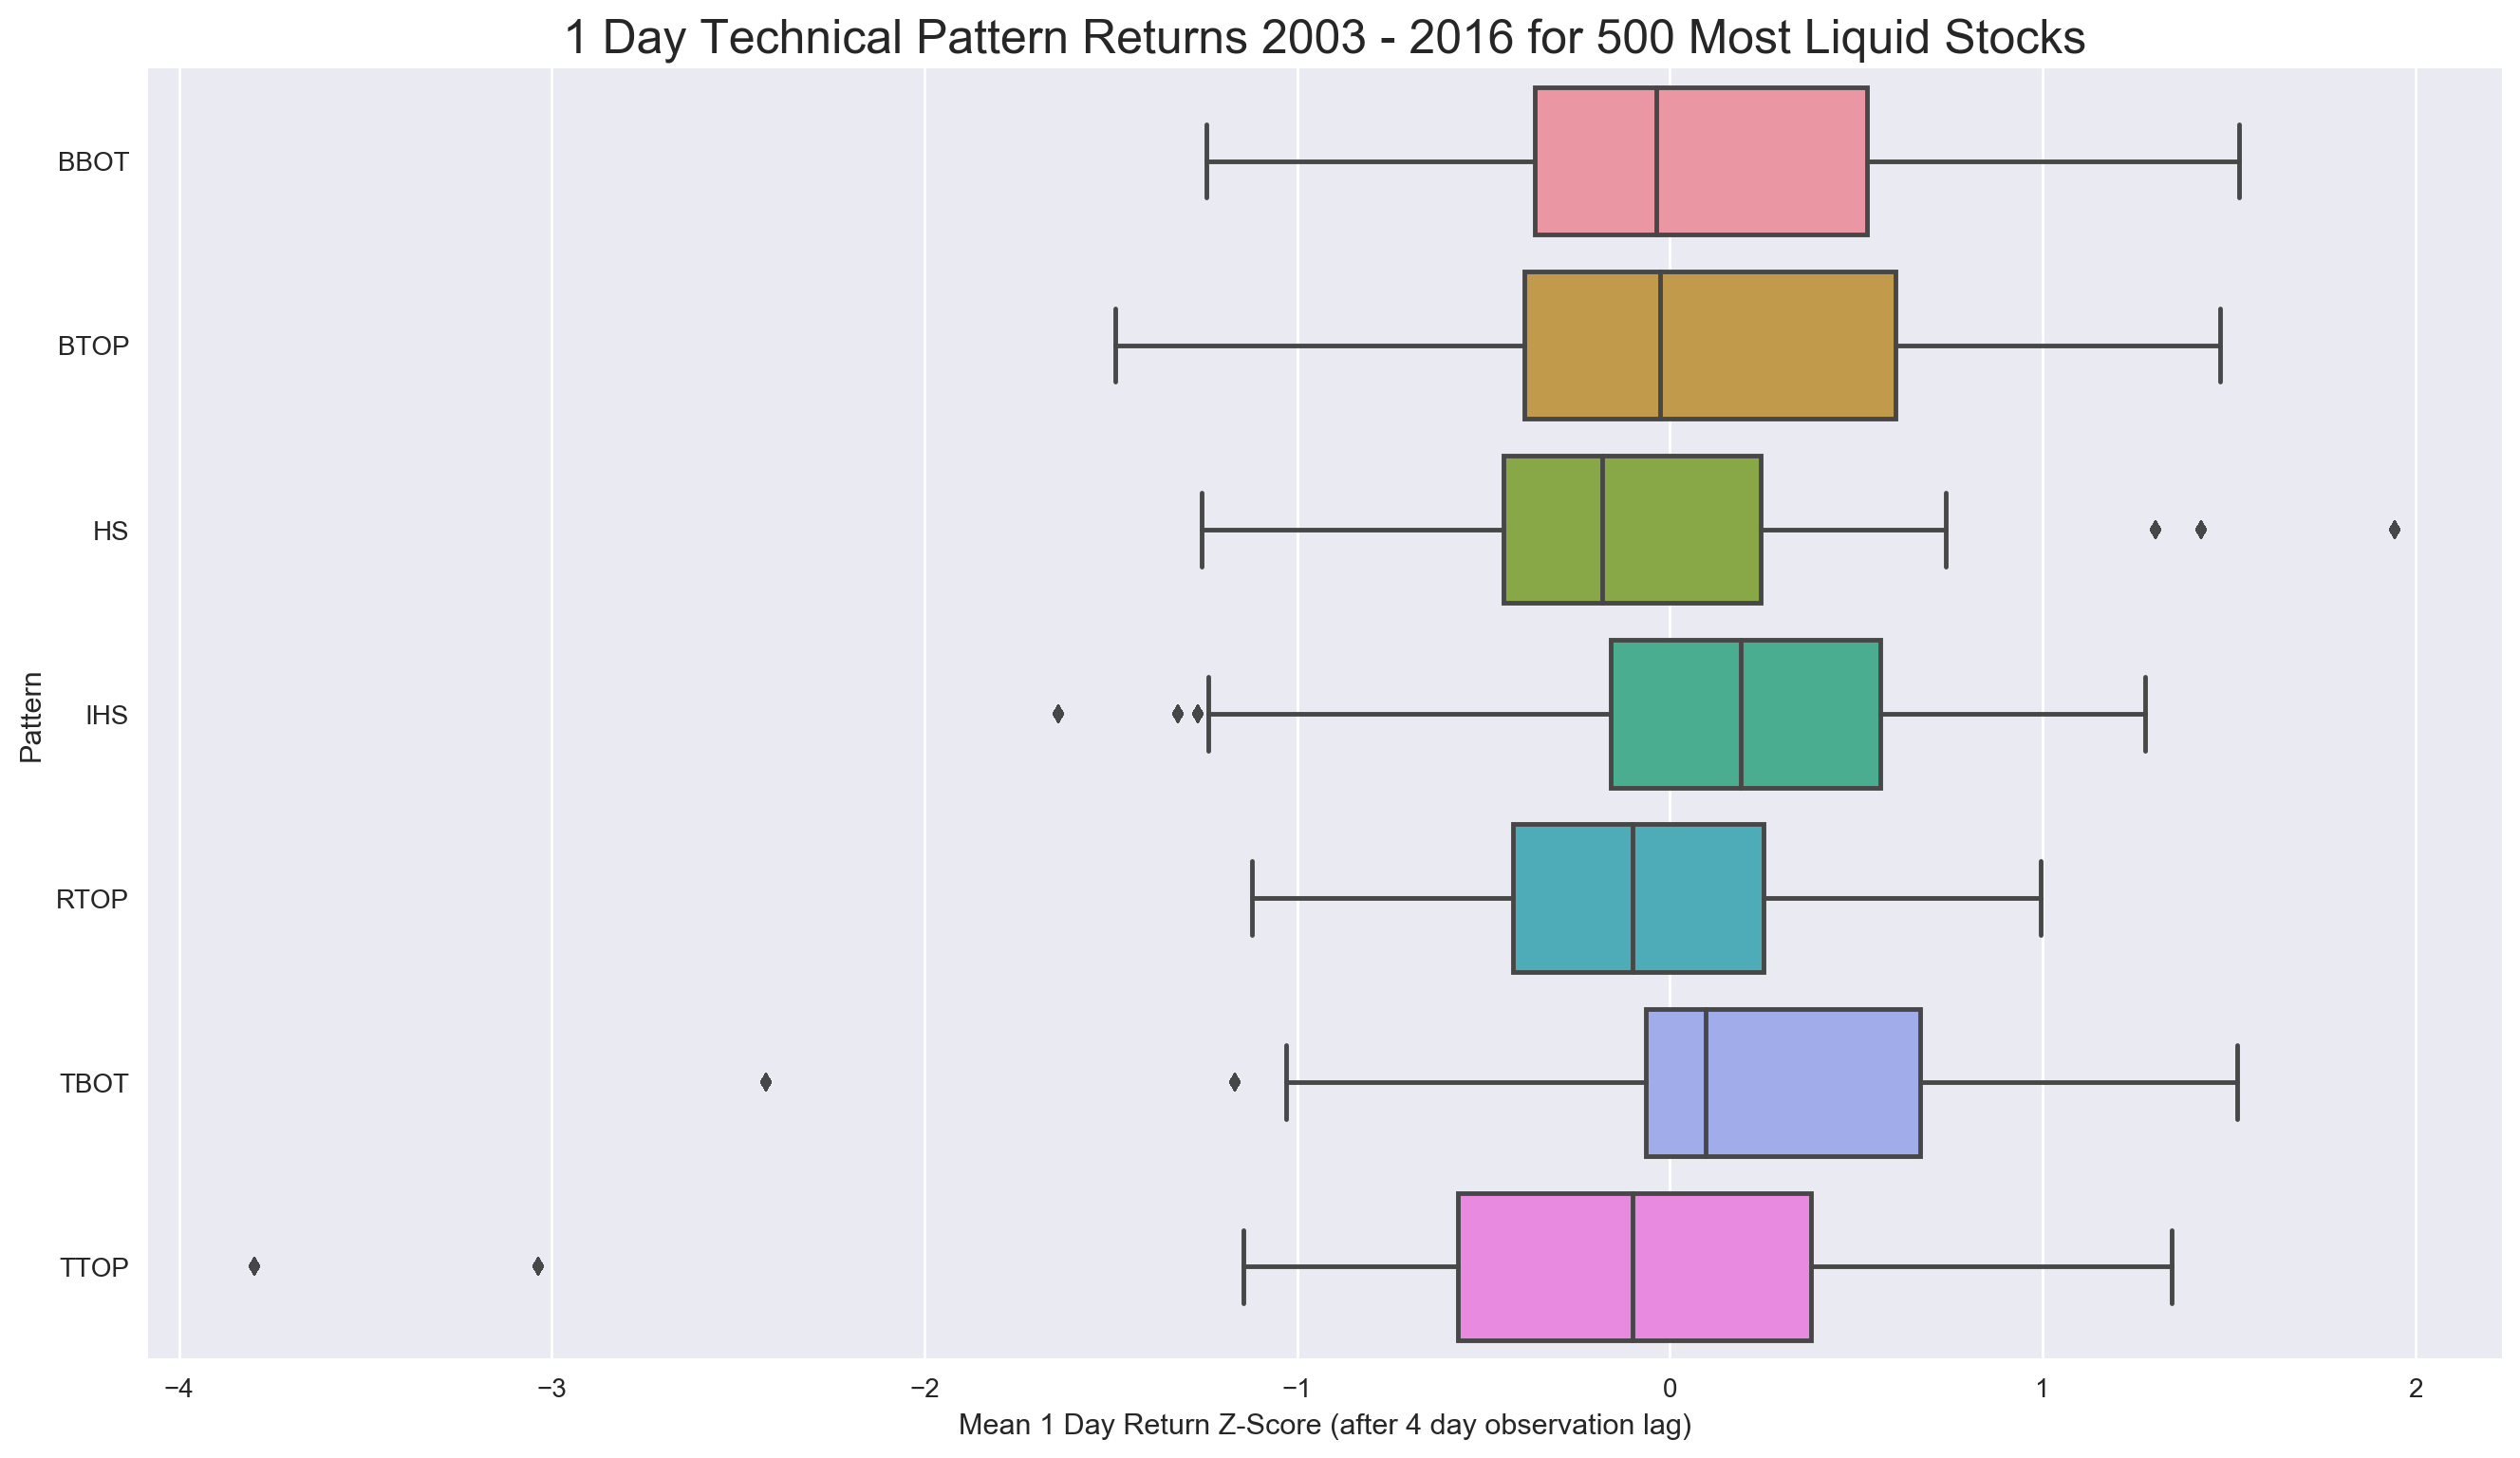

In [273]:
sns.boxplot(y="variable", x="value", data=pd.melt(pattern_returns.T))
plt.title('1 Day Technical Pattern Returns 2017-01 - 2017-12 for 500 Most Liquid Stocks', size=18)
plt.xlabel('Mean 1 Day Return Z-Score (after 4 day observation lag)')
plt.ylabel('Pattern')
plt.show()

Somewhat suprisingly (to me at least), it appears the patterns have significant predicive power with the signs we expected. I'm concerned that the kernel regression was incorperating some lookahead bias that has not been fully mitigated by the four day observation lag. Next step will be to throw this into an algorithm and test for predictive power in a no-look-ahead environment. Please feel free to clone this notebook and use as you see fit!  

In [254]:
pattern_returns

A       AAL       AAP      AAPL      ABBV       ABC      ABMD  \
BBOT       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
BTOP       NaN       NaN       NaN       NaN       NaN       NaN -0.084329   
HS   -0.431478       NaN -0.178731       NaN  0.164514       NaN -0.553192   
IHS   1.039171 -1.641219  0.875706       NaN       NaN  0.529811       NaN   
RTOP       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
TBOT       NaN       NaN  0.050923  0.391629 -0.034189       NaN       NaN   
TTOP       NaN  0.027404       NaN       NaN       NaN -3.036431       NaN   

           ABT       ACN  ADBE    ...          COF       COG       CPB  \
BBOT       NaN -0.640301   NaN    ...          NaN       NaN       NaN   
BTOP       NaN       NaN   NaN    ...          NaN       NaN       NaN   
HS    1.303283       NaN   NaN    ...    -0.383377 -0.173676  0.381190   
IHS  -0.133678       NaN   NaN    ...     1.043297  0.185276  0.454533   
RTOP       NaN       NaN   NaN    ...          NaN -0.451779       NaN   
TBOT       NaN       NaN   NaN    ...    -0.063732  0.744404       NaN   
TTOP       NaN       NaN   NaN    ...          NaN       NaN  0.773019   

          GOOG     GOOGL       KMX       LNT       MMM        MO         T  
BBOT       NaN       NaN       NaN       NaN       NaN  0.355685       NaN  
BTOP       NaN       NaN -1.487740       NaN       NaN -0.628164       NaN  
HS   -0.710051 -1.020577  0.555881  0.425530       NaN       NaN  1.303283  
IHS  -0.173972 -1.266438       NaN  0.666897 -1.238025  1.037434 -0.133678  
RTOP       NaN       NaN       NaN -0.781778       NaN       NaN       NaN  
TBOT       NaN       NaN       NaN -1.166936       NaN       NaN       NaN  
TTOP       NaN       NaN       NaN  1.346015  0.478192       NaN       NaN  

[7 rows x 21156 columns]